### remember to change model saving path!!!

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import os
from torchvision import transforms
import pandas as pd
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm import tqdm
import random
import torch.nn as nn
from dataset import Thyroid_Dataset
from model import Eff_Unet
from HarDMSEG import HarDMSEG
from loss_metric import DiceLoss, IOU_score, StructureLoss, TverskyLoss
from LightMed.model.LightMed import LightMed
from PMFSNet.lib.models.PMFSNet import PMFSNet
from PMFSNet.lib.models.PMFSNet_FFT import PMFSNet_FFT
from hybrid_model_v3 import HybridSegModel

/home/twszbak764/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/twszbak764/.local/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/twszbak764/.local/lib/python3.12/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)


In [2]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [3]:
import wandb
wandb.login()

wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: s960068sss (s960068sss-ucl) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import os
from torchvision import transforms
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms.functional as tx
import random
import cv2
from PIL import ImageEnhance
from skimage.exposure import match_histograms
import torchvision.transforms as T
import torchvision.transforms.functional as F
class Ge_Benq_Dataset(Dataset):
    def __init__(self, csv_file, transform, image_size, training = True):
        self.df = pd.read_csv(csv_file)
        self.transform = transform
        self.image_size = image_size
        self.training = training
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_name = self.df["image_name"][idx]
        mask_name = self.df["mask_name"][idx]
        dataset = self.df["dataset"][idx]
        mask_type = self.df["mask_type"][idx]
        
        if dataset == "ge":
            from_dataset = 1
        elif dataset == "benq":
            from_dataset = 2

        if mask_type == "nodule":
            mask_type = 1
        elif mask_type == "gland":
            mask_type = 2

            
        if dataset == "benq":
            from_folder = "../gland_data"
        elif dataset == "ge":
            if mask_type == 1:
                from_folder = "../ge_data/nodule"
            else:
                from_folder = "../ge_data/gland"
        
        image_path = f"{from_folder}/images/{image_name}"
        mask_path = f"{from_folder}/masks/{mask_name}"

        image = Image.open(image_path).convert("L")
        mask = Image.open(mask_path).convert("L")
        
        image_tensor, mask_tensor = self.transform(image, mask, self.image_size)
        mask_tensor = (mask_tensor > 0.5).float()
        if torch.sum(mask_tensor) == 0:
            # print("nothing")
            return [None]
        return image_tensor, mask_tensor, from_dataset, mask_type

In [5]:
image_size = 128
batch_size = 256
def train_augmentation(image, mask, image_size):
    resize = T.Resize((image_size, image_size))
    image = resize(image)
    mask = resize(mask)

    p = 0.9
    
    # if(random.random() < p):
    #     jitter = T.ColorJitter(brightness = 0.5, contrast = 0.25)
    #     image = jitter(image)
    # if(random.random() < p):
    #     transform = T.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))
    #     image = transform(image)  # image must be a PIL image
    if(random.random() < p):
        # angle = random.uniform(-10, 10)  # 旋轉角度從 ±10 度
        angle = 0.0
        max_dx = 0.05  # 水平平移比例
        max_dy = 0.3  # 垂直平移比例
        translate_x = random.uniform(-max_dx, max_dx) * image.size[0]
        translate_y = random.uniform(-max_dy, max_dy) * image.size[1]
        translate = (int(translate_x), int(translate_y))
        scale = random.uniform(0.9, 1.6)  # 尺度縮放 ±5%
        # scale = 1.0
        # shear = [random.uniform(-5, 5), random.uniform(-5, 5)]  # 小幅剪切
        shear=[0.0, 0.0]
        image = F.affine(image, angle=angle, translate=translate, scale=scale, shear=shear)
        mask = F.affine(mask, angle=angle, translate=translate, scale=scale, shear=shear)

        
    image_tensor = tx.to_tensor(image)
    mask_tensor = tx.to_tensor(mask)

    # If standardization
    mean = image_tensor.mean()
    std = image_tensor.std()
    std = std if std > 0 else 1.0  # avoid division by zero
    image_tensor = (image_tensor - mean) / std
    return image_tensor, mask_tensor
def test_augmentation(image, mask, image_size):
    resize = T.Resize((image_size, image_size))
    image = resize(image)
    mask = resize(mask)

    image_tensor = tx.to_tensor(image)
    mask_tensor = tx.to_tensor(mask)

    # If standardization
    mean = image_tensor.mean()
    std = image_tensor.std()
    std = std if std > 0 else 1.0  # avoid division by zero
    image_tensor = (image_tensor - mean) / std
    return image_tensor, mask_tensor
def custom_collate_fn(batch):
    # print(batch)
    filtered_batch = [item for item in batch if item[0] is not None]
    if len(filtered_batch) == 0:
        return [None, None, None, None]
    return torch.utils.data.dataloader.default_collate(filtered_batch)
train_dataset = Ge_Benq_Dataset("../ge_benq_data/ge(nodule_gland)_benq(gland)_train.csv", transform = train_augmentation, image_size = image_size)
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, collate_fn=custom_collate_fn)

test_dataset = Ge_Benq_Dataset("../ge_benq_data/ge(nodule_gland)_benq(gland)_test.csv", transform = test_augmentation, image_size = image_size, training = False)
test_dataloader = DataLoader(test_dataset, batch_size = 1, shuffle = False, collate_fn=custom_collate_fn)

image, mask, from_dataset, mask_type = next(iter(test_dataloader))

In [6]:
from_dataset

tensor([1])

In [7]:
mask_type

tensor([1])

In [8]:
print(len(train_dataset), len(test_dataset))

788 218


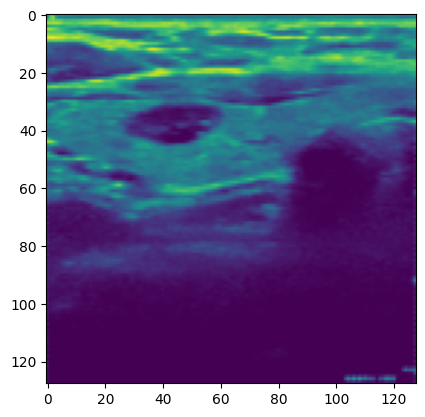

In [9]:
plt.imshow(image[0][0])

In [10]:
def train(dataloader, model, optimizer, loss_fn, device):
    total_loss = 0
    total_IOU = 0
    total_DICE = 0

    total_ge_nodule_IOU = 0
    total_ge_gland_IOU = 0
    total_benq_gland_IOU = 0
    
    total_ge_nodule_DICE = 0
    total_ge_gland_DICE = 0
    total_benq_gland_DICE = 0
    
    model.train()
    model.to(device)
    
    count = 0
    for image, mask, from_dataset, mask_type in tqdm(dataloader):
        if image == None:
            continue
        image, mask = image.to(device), mask.to(device)
        
        outputs = model(image)
        
        nodule_output = outputs[:, 0:1, :, :]
        gland_output = outputs[:, 1:2, :, :]

        # get output
        ge_nodule_output = nodule_output[(from_dataset == 1) & (mask_type == 1)]
        ge_gland_output = gland_output[(from_dataset == 1) & (mask_type == 2)]
        benq_gland_output = gland_output[(from_dataset == 2) & (mask_type == 2)]

        # get len
        ge_nodule_len = ge_nodule_output.shape[0]
        ge_gland_len = ge_gland_output.shape[0]
        benq_gland_len = benq_gland_output.shape[0]

        if ge_nodule_len == 0 or ge_gland_len == 0 or benq_gland_len == 0:
            continue

        nodule_ratio = ge_nodule_len / (ge_nodule_len + ge_gland_len + benq_gland_len)
        gland_ratio = (ge_gland_len + benq_gland_len) / (ge_nodule_len + ge_gland_len + benq_gland_len)
        
        ge_gland_ratio = ge_gland_len / (ge_gland_len + benq_gland_len)
        benq_gland_ratio = benq_gland_len / (ge_gland_len + benq_gland_len)
        
        # get mask
        ge_nodule_mask = mask[(from_dataset == 1) & (mask_type == 1)]
        ge_gland_mask = mask[(from_dataset == 1) & (mask_type == 2)]
        benq_gland_mask = mask[(from_dataset == 2) & (mask_type == 2)]
        
        #get loss
        ge_nodule_loss = loss_fn(ge_nodule_output, ge_nodule_mask)
        ge_gland_loss = loss_fn(ge_gland_output, ge_gland_mask)
        benq_gland_loss = loss_fn(benq_gland_output, benq_gland_mask)

        nodule_loss = ge_nodule_loss
        gland_loss = (ge_gland_loss * ge_gland_ratio + benq_gland_loss * benq_gland_ratio)
        loss = (nodule_loss * nodule_ratio + gland_loss * gland_ratio)
        
        # get IOU
        ge_nodule_IOU = IOU_score(ge_nodule_output, ge_nodule_mask)
        ge_gland_IOU = IOU_score(ge_gland_output, ge_gland_mask)
        benq_gland_IOU = IOU_score(benq_gland_output, benq_gland_mask)

        nodule_IOU = ge_nodule_IOU
        gland_IOU = (ge_gland_IOU * ge_gland_ratio + benq_gland_IOU * benq_gland_ratio)
        IOU = (nodule_IOU * nodule_ratio + gland_IOU * gland_ratio)

        # get DICE
        dice_loss = DiceLoss()
        
        ge_nodule_DICE = 1 - dice_loss(ge_nodule_output, ge_nodule_mask)
        ge_gland_DICE = 1 - dice_loss(ge_gland_output, ge_gland_mask)
        benq_gland_DICE = 1 - dice_loss(benq_gland_output, benq_gland_mask)

        nodule_DICE = ge_nodule_DICE
        gland_DICE = (ge_gland_DICE * ge_gland_ratio + benq_gland_DICE * benq_gland_ratio)
        DICE = (nodule_DICE * nodule_ratio + gland_DICE * gland_ratio)

        
        # Backward and optimize
        optimizer.zero_grad()   # clear previous gradients
        loss.backward()         # compute gradients
        optimizer.step()        # update weights

        total_loss += loss.item()
        total_IOU += IOU.item()
        total_DICE += DICE.item()

        total_ge_nodule_IOU += ge_nodule_IOU
        total_ge_gland_IOU += ge_gland_IOU
        total_benq_gland_IOU += benq_gland_IOU

        total_ge_nodule_DICE += ge_nodule_DICE
        total_ge_gland_DICE += ge_gland_DICE
        total_benq_gland_DICE += benq_gland_DICE
        count+=1

    return total_loss/count, total_IOU/count, total_DICE/count, total_ge_nodule_IOU/count, total_ge_gland_IOU/count, total_benq_gland_IOU/count, total_ge_nodule_DICE/count, total_ge_gland_DICE/count, total_benq_gland_DICE/count


# 
# Only calculate nodule loss, IOU, DICE, because there is no gland data in the testing set
def val(dataloader, model, loss_fn, device):
    total_loss = 0
    total_IOU = 0
    total_DICE = 0

    ge_nodule_IOU = 0
    ge_gland_IOU = 0
    benq_gland_IOU = 0

    ge_nodule_DICE = 0
    ge_gland_DICE = 0
    benq_gland_DICE = 0

    ge_nodule_count = 0
    ge_gland_count = 0
    benq_gland_count = 0
    
    model.eval()
    model.to(device)
    
    for image, mask, from_dataset, mask_type in tqdm(dataloader):
        if image == None:
            continue
            
        image, mask = image.to(device), mask.to(device)
        
        outputs = model(image)
        nodule_output = outputs[:, 0:1, :, :]
        gland_output = outputs[:, 1:2, :, :]

        ge_nodule_output = nodule_output[(from_dataset == 1) & (mask_type == 1)]
        ge_gland_output = gland_output[(from_dataset == 1) & (mask_type == 2)]
        benq_gland_output = gland_output[(from_dataset == 2) & (mask_type == 2)]

        ge_nodule_mask = mask[(from_dataset == 1) & (mask_type == 1)]
        ge_gland_mask = mask[(from_dataset == 1) & (mask_type == 2)]
        benq_gland_mask = mask[(from_dataset == 2) & (mask_type == 2)]
        
        if from_dataset[0] == 1 and mask_type[0] == 1:
            loss = loss_fn(ge_nodule_output, ge_nodule_mask)
            IOU = IOU_score(ge_nodule_output, ge_nodule_mask)
            dice_loss = DiceLoss()
            DICE = 1 - dice_loss(ge_nodule_output, ge_nodule_mask)

            ge_nodule_IOU += IOU.item()
            ge_nodule_DICE += DICE.item()
            total_loss += loss.item()
            total_IOU += IOU.item()
            total_DICE += DICE.item()
            ge_nodule_count += 1
        elif from_dataset[0] == 1 and mask_type[0] == 2:
            loss = loss_fn(ge_gland_output, ge_gland_mask)
            IOU = IOU_score(ge_gland_output, ge_gland_mask)
            dice_loss = DiceLoss()
            DICE = 1 - dice_loss(ge_gland_output, ge_gland_mask)

            ge_gland_IOU += IOU.item()
            ge_gland_DICE += DICE.item()
            total_loss += loss.item()
            total_IOU += IOU.item()
            total_DICE += DICE.item()
            ge_gland_count += 1
        elif from_dataset[0] == 2 and mask_type[0] == 2:
            loss = loss_fn(benq_gland_output, benq_gland_mask)
            IOU = IOU_score(benq_gland_output, benq_gland_mask)
            dice_loss = DiceLoss()
            DICE = 1 - dice_loss(benq_gland_output, benq_gland_mask)
            
            benq_gland_IOU += IOU.item()
            benq_gland_DICE += DICE.item()
            total_loss += loss.item()
            total_IOU += IOU.item()
            total_DICE += DICE.item()
            benq_gland_count += 1
    count = (ge_nodule_count + ge_gland_count + benq_gland_count)
    return total_loss/count , total_IOU/count, total_DICE/count, ge_nodule_IOU/ge_nodule_count, ge_gland_IOU/ge_gland_count, benq_gland_IOU/benq_gland_count, ge_nodule_DICE/ge_nodule_count, ge_gland_DICE/ge_gland_count, benq_gland_DICE/benq_gland_count


In [11]:

# inference_name = "models/Phase 1/Hybrid_crop_DDTI_standardization_aug_affine(0.5)_for_gland"
model = HybridSegModel(in_channels = 1, out_channels = 2, output_size = image_size, layers_num = 3, arch = 68, depth_wise = True, synthesize_adaptive_max_pool = True)
# checkpoint = torch.load(f"{inference_name}/best_checkpoint.pth")
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

In [12]:
# # freeze encoder
# for param in model.backbone.parameters():
#     param.requires_grad = False

In [13]:

epochs = 300
lr = 0.01
loss_fn = StructureLoss()
# loss_fn = TverskyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay = 1e-4)
# optimizer = optim.AdamW(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

In [14]:

project = "thyroid_ge_benq_from_scratch"
name = "hybrid_model(68_depth_wise_synthesize_adaptive_max_pool)_ge(nodule_gland)_benq(gland)_from_scratch_v1_aug_space(0.9)_weight_decay(1e-4)"
# name = "test"

wandb.init(
    project = project,  # Project name in W&B
    name = name,       # (optional) specific run name
    config={                     # (optional) hyperparameters
        "image_size": image_size,
        "learning_rate": lr,
        "epochs": epochs,
        "batch_size": batch_size,
        "augmentation" : "space(0.9)",
        "weight_decay":1e-4
    }
)

In [15]:
print(f"image size : {image_size}, lr : {lr}, epochs : {epochs}, batch size : {batch_size}")

image size : 128, lr : 0.01, epochs : 300, batch size : 256


In [16]:
max_IOU = -1
for epoch in range(epochs):
    print(f"epoch : {epoch}")
    total_loss_train, total_IOU_train, total_DICE_train, ge_nodule_IOU_train, ge_gland_IOU_train, benq_gland_IOU_train, ge_nodule_DICE_train, ge_gland_DICE_train, benq_gland_DICE_train = train(train_dataloader, model, optimizer, loss_fn, "cuda")
    print(f"train loss : {total_loss_train}, train IOU : {total_IOU_train}, train DICE : {total_DICE_train}")
    total_loss_val, total_IOU_val, total_DICE_val, ge_nodule_IOU_val, ge_gland_IOU_val, benq_gland_IOU_val, ge_nodule_DICE_val, ge_gland_DICE_val, benq_gland_DICE_val = val(test_dataloader, model, loss_fn, "cuda")
    print(f"val loss : {total_loss_val}, val IOU : {total_IOU_val}, val DICE : {total_DICE_val}")
    
    scheduler.step()
    current_lr = scheduler.get_last_lr()[0]



    if max_IOU < total_IOU_val:
        max_IOU = total_IOU_val
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            "IOU" : total_IOU_val,
            "DICE" : total_DICE_val,
            "loss" : total_loss_val
        }
        folder = f"models/from_scratch/ge_benq/{name}/"
        if not os.path.exists(folder):
            os.mkdir(folder)
        torch.save(checkpoint, f"models/from_scratch/ge_benq/{name}/best_checkpoint.pth")

    
    wandb.log({
        "epoch": epoch,
        "Learning Rate":current_lr,
        
        "train_loss": total_loss_train,
        "train_IOU": total_IOU_train,
        "train_DICE": total_DICE_train,
        "train_ge_nodule_IOU" : ge_nodule_IOU_train,
        "train_ge_nodule_DICE" : ge_nodule_DICE_train,
        "train_ge_gland_IOU" : ge_gland_IOU_train,
        "train_ge_gland_DICE" : ge_gland_DICE_train,
        "train_benq_gland_IOU" : benq_gland_IOU_train,
        "train_benq_gland_DICE" : benq_gland_DICE_train,
        
        "val_loss": total_loss_val,
        "val_IOU": total_IOU_val,
        "val_DICE": total_DICE_val,
        "val_ge_nodule_IOU" : ge_nodule_IOU_val,
        "val_ge_nodule_DICE" : ge_nodule_DICE_val,
        "val_ge_gland_IOU" : ge_gland_IOU_val,
        "val_ge_gland_DICE" : ge_gland_DICE_val,
        "val_benq_gland_IOU" : benq_gland_IOU_val,
        "val_benq_gland_DICE" : benq_gland_DICE_val,
        
    })




checkpoint = {
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    "IOU" : total_IOU_val,
    "DICE" : total_DICE_val,
    "loss" : total_loss_val
}
torch.save(checkpoint, f"models/from_scratch/ge_benq/{name}/last_checkpoint.pth")
wandb.finish()

epoch : 0


/home/twszbak764/miniconda3/envs/thyroid/lib/python3.12/site-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
100%|██████████| 4/4 [00:11<00:00,  2.78s/it]


train loss : 1.2525774836540222, train IOU : 0.1507608899846673, train DICE : 0.21224544569849968


100%|██████████| 218/218 [00:05<00:00, 38.87it/s]


val loss : 1.1760751869943407, val IOU : 8.900975439311491e-10, val DICE : 0.17978595814319573
epoch : 1


100%|██████████| 4/4 [00:10<00:00,  2.59s/it]


train loss : 0.9822529554367065, train IOU : 0.18084864566723505, train DICE : 0.3356317381064097


100%|██████████| 218/218 [00:05<00:00, 39.22it/s]


val loss : 1.155166061839672, val IOU : 0.0018808040999612576, val DICE : 0.18288367143785111
epoch : 2


100%|██████████| 4/4 [00:10<00:00,  2.64s/it]


train loss : 0.9015758484601974, train IOU : 0.32350465655326843, train DICE : 0.40139517933130264


100%|██████████| 218/218 [00:05<00:00, 38.68it/s]


val loss : 1.1134170146301539, val IOU : 0.20141906390204328, val DICE : 0.23013569700597514
epoch : 3


100%|██████████| 4/4 [00:10<00:00,  2.62s/it]


train loss : 0.8100903630256653, train IOU : 0.40907567739486694, train DICE : 0.5021387711167336


100%|██████████| 218/218 [00:05<00:00, 38.37it/s]


val loss : 1.1422648071640669, val IOU : 0.2134635691346956, val DICE : 0.30468984475039473
epoch : 4


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


train loss : 0.7869817912578583, train IOU : 0.40471482276916504, train DICE : 0.5283790081739426


100%|██████████| 218/218 [00:05<00:00, 38.68it/s]


val loss : 1.1364008853531846, val IOU : 0.19368572500386377, val DICE : 0.23360118029093502
epoch : 5


100%|██████████| 4/4 [00:10<00:00,  2.71s/it]


train loss : 0.6988265663385391, train IOU : 0.4586575925350189, train DICE : 0.5659037679433823


100%|██████████| 218/218 [00:05<00:00, 38.91it/s]


val loss : 1.126253292717115, val IOU : 0.2353953688019068, val DICE : 0.2586756914553016
epoch : 6


100%|██████████| 4/4 [00:10<00:00,  2.61s/it]


train loss : 0.6450263261795044, train IOU : 0.514522910118103, train DICE : 0.6244283616542816


100%|██████████| 218/218 [00:05<00:00, 38.81it/s]


val loss : 1.0603831422449363, val IOU : 0.25853379731069054, val DICE : 0.322154171840109
epoch : 7


100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


train loss : 0.6122845560312271, train IOU : 0.5197889357805252, train DICE : 0.6472453325986862


100%|██████████| 218/218 [00:05<00:00, 38.47it/s]


val loss : 1.045805326013854, val IOU : 0.2606757153641548, val DICE : 0.3129094321318347
epoch : 8


100%|██████████| 4/4 [00:10<00:00,  2.60s/it]


train loss : 0.6066249459981918, train IOU : 0.549919918179512, train DICE : 0.6621937900781631


100%|██████████| 218/218 [00:05<00:00, 38.85it/s]


val loss : 1.02767680088679, val IOU : 0.2834844100636514, val DICE : 0.3465200728840298
epoch : 9


100%|██████████| 4/4 [00:10<00:00,  2.57s/it]


train loss : 0.5625158548355103, train IOU : 0.5636332829793295, train DICE : 0.6930088003476461


100%|██████████| 218/218 [00:05<00:00, 39.16it/s]


val loss : 1.0878796788177105, val IOU : 0.2589192764381558, val DICE : 0.3084249824586541
epoch : 10


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


train loss : 0.5437790155410767, train IOU : 0.5713247805833817, train DICE : 0.6972264349460602


100%|██████████| 218/218 [00:05<00:00, 38.15it/s]


val loss : 1.0916285177673957, val IOU : 0.264470681449859, val DICE : 0.3242246592887724
epoch : 11


100%|██████████| 4/4 [00:10<00:00,  2.59s/it]


train loss : 0.5174842476844788, train IOU : 0.5868259519338608, train DICE : 0.7070037871599197


100%|██████████| 218/218 [00:05<00:00, 38.54it/s]


val loss : 0.9885214365491963, val IOU : 0.31982111850973843, val DICE : 0.412459547772552
epoch : 12


100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


train loss : 0.46952682733535767, train IOU : 0.634132444858551, train DICE : 0.7439844310283661


100%|██████████| 218/218 [00:05<00:00, 39.11it/s]


val loss : 0.9853021949529648, val IOU : 0.32065236042083367, val DICE : 0.3993960537693717
epoch : 13


100%|██████████| 4/4 [00:10<00:00,  2.61s/it]


train loss : 0.4664650037884712, train IOU : 0.6482599675655365, train DICE : 0.7589486241340637


100%|██████████| 218/218 [00:05<00:00, 38.28it/s]


val loss : 0.845793794200878, val IOU : 0.41082276594894124, val DICE : 0.505385340163202
epoch : 14


100%|██████████| 4/4 [00:10<00:00,  2.61s/it]


train loss : 0.45166680961847305, train IOU : 0.6413143426179886, train DICE : 0.7583338618278503


100%|██████████| 218/218 [00:05<00:00, 38.47it/s]


val loss : 0.910036881614213, val IOU : 0.3538004765189329, val DICE : 0.45342634031266876
epoch : 15


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


train loss : 0.45912081003189087, train IOU : 0.6476183533668518, train DICE : 0.7737066745758057


100%|██████████| 218/218 [00:05<00:00, 39.13it/s]


val loss : 0.7156352996073588, val IOU : 0.49894559672541033, val DICE : 0.6073029375437534
epoch : 16


100%|██████████| 4/4 [00:10<00:00,  2.64s/it]


train loss : 0.4396013915538788, train IOU : 0.6626834720373154, train DICE : 0.7840492129325867


100%|██████████| 218/218 [00:05<00:00, 38.40it/s]


val loss : 0.7600031592177622, val IOU : 0.47599311066460803, val DICE : 0.5842641856935289
epoch : 17


100%|██████████| 4/4 [00:10<00:00,  2.62s/it]


train loss : 0.42194120089213055, train IOU : 0.6732780734697977, train DICE : 0.7913808226585388


100%|██████████| 218/218 [00:05<00:00, 39.00it/s]


val loss : 0.822702292390544, val IOU : 0.43345977665757307, val DICE : 0.5418650354399825
epoch : 18


100%|██████████| 4/4 [00:10<00:00,  2.60s/it]


train loss : 0.4120035693049431, train IOU : 0.6600477397441864, train DICE : 0.7966142296791077


100%|██████████| 218/218 [00:05<00:00, 38.47it/s]


val loss : 0.8250479814831657, val IOU : 0.4319129754135426, val DICE : 0.5499111760144282
epoch : 19


100%|██████████| 4/4 [00:10<00:00,  2.60s/it]


train loss : 0.39566896855831146, train IOU : 0.7036482989788055, train DICE : 0.8192463666200638


100%|██████████| 218/218 [00:05<00:00, 38.27it/s]


val loss : 0.7110805861426123, val IOU : 0.5187201145674989, val DICE : 0.6259718498196265
epoch : 20


100%|██████████| 4/4 [00:10<00:00,  2.61s/it]


train loss : 0.3830414613087972, train IOU : 0.6918044487635294, train DICE : 0.8096289237340292


100%|██████████| 218/218 [00:05<00:00, 38.71it/s]


val loss : 0.6338097030917803, val IOU : 0.5708210494937183, val DICE : 0.6783837104084516
epoch : 21


100%|██████████| 4/4 [00:10<00:00,  2.62s/it]


train loss : 0.37452220916748047, train IOU : 0.7214738875627518, train DICE : 0.8253827095031738


100%|██████████| 218/218 [00:05<00:00, 38.05it/s]


val loss : 0.5979096866918333, val IOU : 0.6032199690992429, val DICE : 0.7006587051984036
epoch : 22


100%|██████████| 4/4 [00:10<00:00,  2.63s/it]


train loss : 0.3519192934036255, train IOU : 0.7202404141426086, train DICE : 0.8212290406227112


100%|██████████| 218/218 [00:05<00:00, 38.29it/s]


val loss : 1.155825454628829, val IOU : 0.30454018689449186, val DICE : 0.39131717940773625
epoch : 23


100%|██████████| 4/4 [00:10<00:00,  2.55s/it]


train loss : 0.38380373269319534, train IOU : 0.7124514132738113, train DICE : 0.8225287348031998


100%|██████████| 218/218 [00:05<00:00, 38.90it/s]


val loss : 0.6527325674289405, val IOU : 0.5625043825546546, val DICE : 0.6613538752902638
epoch : 24


100%|██████████| 4/4 [00:10<00:00,  2.64s/it]


train loss : 0.3663966581225395, train IOU : 0.7125049233436584, train DICE : 0.8176575750112534


100%|██████████| 218/218 [00:05<00:00, 38.47it/s]


val loss : 0.6374777184441837, val IOU : 0.5738182520175162, val DICE : 0.6807752712206407
epoch : 25


100%|██████████| 4/4 [00:10<00:00,  2.60s/it]


train loss : 0.35943081974983215, train IOU : 0.7221150100231171, train DICE : 0.8372110724449158


100%|██████████| 218/218 [00:05<00:00, 38.55it/s]


val loss : 0.6071910989103895, val IOU : 0.588024288919066, val DICE : 0.6878265232750864
epoch : 26


100%|██████████| 4/4 [00:10<00:00,  2.59s/it]


train loss : 0.36948589980602264, train IOU : 0.7139384746551514, train DICE : 0.8117110282182693


100%|██████████| 218/218 [00:05<00:00, 38.47it/s]


val loss : 0.6217035165037772, val IOU : 0.5925622116627621, val DICE : 0.6910028189721734
epoch : 27


100%|██████████| 4/4 [00:10<00:00,  2.65s/it]


train loss : 0.3517976924777031, train IOU : 0.7279111593961716, train DICE : 0.8351521342992783


100%|██████████| 218/218 [00:05<00:00, 38.40it/s]


val loss : 0.4917066927359562, val IOU : 0.6689398856575112, val DICE : 0.7522896687791805
epoch : 28


100%|██████████| 4/4 [00:10<00:00,  2.59s/it]


train loss : 0.35060398777325946, train IOU : 0.7204026579856873, train DICE : 0.8335135181744894


100%|██████████| 218/218 [00:05<00:00, 39.19it/s]


val loss : 0.4973459000689815, val IOU : 0.6623833956090888, val DICE : 0.7519054229211326
epoch : 29


100%|██████████| 4/4 [00:10<00:00,  2.59s/it]


train loss : 0.3319026231765747, train IOU : 0.7630652636289597, train DICE : 0.8592217564582825


100%|██████████| 218/218 [00:05<00:00, 37.79it/s]


val loss : 0.5441471245704275, val IOU : 0.6458047026663966, val DICE : 0.7471579451753636
epoch : 30


100%|██████████| 4/4 [00:10<00:00,  2.65s/it]


train loss : 0.31666071712970734, train IOU : 0.7434990853071213, train DICE : 0.8551956117153168


100%|██████████| 218/218 [00:05<00:00, 38.30it/s]


val loss : 0.6232281471743728, val IOU : 0.5873836745240368, val DICE : 0.6930111276380944
epoch : 31


100%|██████████| 4/4 [00:10<00:00,  2.57s/it]


train loss : 0.31296538561582565, train IOU : 0.767600804567337, train DICE : 0.8638397604227066


100%|██████████| 218/218 [00:05<00:00, 38.84it/s]


val loss : 0.597970207155955, val IOU : 0.6029729729935224, val DICE : 0.7029837165216003
epoch : 32


100%|██████████| 4/4 [00:10<00:00,  2.63s/it]


train loss : 0.3198416903614998, train IOU : 0.756403386592865, train DICE : 0.8566688597202301


100%|██████████| 218/218 [00:05<00:00, 38.07it/s]


val loss : 0.6821458350979921, val IOU : 0.5543962470135014, val DICE : 0.6601524316903317
epoch : 33


100%|██████████| 4/4 [00:10<00:00,  2.61s/it]


train loss : 0.3508470952510834, train IOU : 0.7453514784574509, train DICE : 0.8465636670589447


100%|██████████| 218/218 [00:05<00:00, 38.05it/s]


val loss : 0.5615978348586295, val IOU : 0.624471083177156, val DICE : 0.7263022330072191
epoch : 34


100%|██████████| 4/4 [00:10<00:00,  2.60s/it]


train loss : 0.3237157613039017, train IOU : 0.7521571516990662, train DICE : 0.8597961664199829


100%|██████████| 218/218 [00:05<00:00, 38.75it/s]


val loss : 0.6500346059299479, val IOU : 0.57065304822746, val DICE : 0.6797370308577412
epoch : 35


100%|██████████| 4/4 [00:10<00:00,  2.67s/it]


train loss : 0.30080564320087433, train IOU : 0.7739731073379517, train DICE : 0.8704122751951218


100%|██████████| 218/218 [00:05<00:00, 38.38it/s]


val loss : 0.5810539897042092, val IOU : 0.5996042926781394, val DICE : 0.7080093354287774
epoch : 36


100%|██████████| 4/4 [00:10<00:00,  2.63s/it]


train loss : 0.31689106673002243, train IOU : 0.7594541609287262, train DICE : 0.8633152842521667


100%|██████████| 218/218 [00:05<00:00, 38.98it/s]


val loss : 0.5160958231850103, val IOU : 0.6480913612228699, val DICE : 0.7489666809337308
epoch : 37


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


train loss : 0.2986726611852646, train IOU : 0.7714428752660751, train DICE : 0.8717028945684433


100%|██████████| 218/218 [00:05<00:00, 38.40it/s]


val loss : 0.5124710356496801, val IOU : 0.6584748216408711, val DICE : 0.7569691635141469
epoch : 38


100%|██████████| 4/4 [00:10<00:00,  2.62s/it]


train loss : 0.3230834975838661, train IOU : 0.7437513917684555, train DICE : 0.8535610884428024


100%|██████████| 218/218 [00:05<00:00, 38.31it/s]


val loss : 0.5558316314009705, val IOU : 0.6390296330886316, val DICE : 0.7393110806893821
epoch : 39


100%|██████████| 4/4 [00:10<00:00,  2.63s/it]


train loss : 0.31653372198343277, train IOU : 0.7527160197496414, train DICE : 0.8620708286762238


100%|██████████| 218/218 [00:05<00:00, 39.25it/s]


val loss : 0.529487483955995, val IOU : 0.6559069056976281, val DICE : 0.7590922704248717
epoch : 40


100%|██████████| 4/4 [00:10<00:00,  2.60s/it]


train loss : 0.3162744790315628, train IOU : 0.7369210422039032, train DICE : 0.8551720231771469


100%|██████████| 218/218 [00:05<00:00, 38.43it/s]


val loss : 0.5663798100719548, val IOU : 0.6360973937393378, val DICE : 0.7429633826920481
epoch : 41


100%|██████████| 4/4 [00:10<00:00,  2.59s/it]


train loss : 0.3269690126180649, train IOU : 0.7434338629245758, train DICE : 0.8460799753665924


100%|██████████| 218/218 [00:05<00:00, 38.13it/s]


val loss : 0.5619963494063628, val IOU : 0.6338084434822315, val DICE : 0.7320495955269746
epoch : 42


100%|██████████| 4/4 [00:10<00:00,  2.61s/it]


train loss : 0.31023579835891724, train IOU : 0.7673035264015198, train DICE : 0.8679926991462708


100%|██████████| 218/218 [00:05<00:00, 38.79it/s]


val loss : 0.5345681344695163, val IOU : 0.6452593075596685, val DICE : 0.7487132169983604
epoch : 43


100%|██████████| 4/4 [00:10<00:00,  2.69s/it]


train loss : 0.3099164466063182, train IOU : 0.7657480637232462, train DICE : 0.8716776569684347


100%|██████████| 218/218 [00:05<00:00, 38.62it/s]


val loss : 0.5870052454146472, val IOU : 0.6191419536673571, val DICE : 0.7269475125905239
epoch : 44


100%|██████████| 4/4 [00:10<00:00,  2.65s/it]


train loss : 0.3014048561453819, train IOU : 0.7777810245752335, train DICE : 0.8732824921607971


100%|██████████| 218/218 [00:05<00:00, 38.65it/s]


val loss : 0.6050792837684805, val IOU : 0.6181259420767332, val DICE : 0.726143833964762
epoch : 45


100%|██████████| 4/4 [00:10<00:00,  2.53s/it]


train loss : 0.30346590280532837, train IOU : 0.7544035712877909, train DICE : 0.8641406297683716


100%|██████████| 218/218 [00:05<00:00, 38.85it/s]


val loss : 0.5862016372683675, val IOU : 0.6185711154413899, val DICE : 0.7206872307290935
epoch : 46


100%|██████████| 4/4 [00:10<00:00,  2.64s/it]


train loss : 0.3019508942961693, train IOU : 0.7692480236291885, train DICE : 0.8728214800357819


100%|██████████| 218/218 [00:05<00:00, 38.90it/s]


val loss : 0.4723748607993728, val IOU : 0.6897673865218487, val DICE : 0.7821766646823498
epoch : 47


100%|██████████| 4/4 [00:10<00:00,  2.57s/it]


train loss : 0.28576526045799255, train IOU : 0.787164052327474, train DICE : 0.8798427184422811


100%|██████████| 218/218 [00:05<00:00, 38.99it/s]


val loss : 0.47893601426421994, val IOU : 0.6806236491699823, val DICE : 0.7770464158419407
epoch : 48


100%|██████████| 4/4 [00:10<00:00,  2.54s/it]


train loss : 0.28906652331352234, train IOU : 0.7737323194742203, train DICE : 0.872029036283493


100%|██████████| 218/218 [00:05<00:00, 38.69it/s]


val loss : 0.5031788799949367, val IOU : 0.6539373056646275, val DICE : 0.7542601080253871
epoch : 49


100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


train loss : 0.2911377549171448, train IOU : 0.7783609429995219, train DICE : 0.8732667565345764


100%|██████████| 218/218 [00:05<00:00, 38.59it/s]


val loss : 0.45914365091558657, val IOU : 0.6946240912990795, val DICE : 0.7811366677886308
epoch : 50


100%|██████████| 4/4 [00:10<00:00,  2.63s/it]


train loss : 0.2713981494307518, train IOU : 0.7789809107780457, train DICE : 0.8828604519367218


100%|██████████| 218/218 [00:05<00:00, 38.95it/s]


val loss : 0.4691530680566123, val IOU : 0.6908166655620638, val DICE : 0.7827725169634578
epoch : 51


100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


train loss : 0.2708382084965706, train IOU : 0.7864750921726227, train DICE : 0.8857474625110626


100%|██████████| 218/218 [00:05<00:00, 37.84it/s]


val loss : 0.4591601374700214, val IOU : 0.6948143423444333, val DICE : 0.7832987916589987
epoch : 52


100%|██████████| 4/4 [00:10<00:00,  2.60s/it]


train loss : 0.26433151215314865, train IOU : 0.7921979278326035, train DICE : 0.8895961195230484


100%|██████████| 218/218 [00:05<00:00, 37.88it/s]


val loss : 0.48220519887076485, val IOU : 0.659892557355106, val DICE : 0.7562653578893103
epoch : 53


100%|██████████| 4/4 [00:10<00:00,  2.63s/it]


train loss : 0.3063962161540985, train IOU : 0.772093191742897, train DICE : 0.8602045625448227


100%|██████████| 218/218 [00:05<00:00, 38.77it/s]


val loss : 0.4935502502879109, val IOU : 0.6699687623977019, val DICE : 0.763960124266268
epoch : 54


100%|██████████| 4/4 [00:10<00:00,  2.62s/it]


train loss : 0.3102666288614273, train IOU : 0.7539552450180054, train DICE : 0.8662956357002258


100%|██████████| 218/218 [00:05<00:00, 37.70it/s]


val loss : 0.5764597714549363, val IOU : 0.6013786433188087, val DICE : 0.7089182541827963
epoch : 55


100%|██████████| 4/4 [00:10<00:00,  2.59s/it]


train loss : 0.2737970252831777, train IOU : 0.7841678857803345, train DICE : 0.8819053173065186


100%|██████████| 218/218 [00:05<00:00, 38.27it/s]


val loss : 0.4912854420642058, val IOU : 0.6594582867688289, val DICE : 0.7572116704300197
epoch : 56


100%|██████████| 4/4 [00:10<00:00,  2.60s/it]


train loss : 0.2678402165571849, train IOU : 0.7905513842900594, train DICE : 0.8885645071665446


100%|██████████| 218/218 [00:05<00:00, 38.80it/s]


val loss : 0.4491589397116743, val IOU : 0.6981788628330134, val DICE : 0.7901064943183552
epoch : 57


100%|██████████| 4/4 [00:10<00:00,  2.61s/it]


train loss : 0.26322023570537567, train IOU : 0.7986131012439728, train DICE : 0.8912500143051147


100%|██████████| 218/218 [00:05<00:00, 38.40it/s]


val loss : 0.468070222986768, val IOU : 0.7027387240468853, val DICE : 0.7982787110588767
epoch : 58


100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


train loss : 0.25086668878793716, train IOU : 0.8036756962537766, train DICE : 0.8990905284881592


100%|██████████| 218/218 [00:05<00:00, 38.92it/s]


val loss : 0.43948596794948436, val IOU : 0.7139599083198441, val DICE : 0.8016230304433842
epoch : 59


100%|██████████| 4/4 [00:10<00:00,  2.60s/it]


train loss : 0.24334051460027695, train IOU : 0.8092205971479416, train DICE : 0.8973413556814194


100%|██████████| 218/218 [00:05<00:00, 38.51it/s]


val loss : 0.4076258543916423, val IOU : 0.7303037282451047, val DICE : 0.8168321266920879
epoch : 60


100%|██████████| 4/4 [00:10<00:00,  2.64s/it]


train loss : 0.24849101528525352, train IOU : 0.8058181256055832, train DICE : 0.8931085467338562


100%|██████████| 218/218 [00:05<00:00, 38.45it/s]


val loss : 0.4216403728256924, val IOU : 0.725506261708826, val DICE : 0.8143353152154672
epoch : 61


100%|██████████| 4/4 [00:10<00:00,  2.60s/it]


train loss : 0.24105944484472275, train IOU : 0.8111020028591156, train DICE : 0.8995225429534912


100%|██████████| 218/218 [00:05<00:00, 39.24it/s]


val loss : 0.42472824446781715, val IOU : 0.7246012979685658, val DICE : 0.8099989517770633
epoch : 62


100%|██████████| 4/4 [00:10<00:00,  2.57s/it]


train loss : 0.24665243923664093, train IOU : 0.808029979467392, train DICE : 0.8929208815097809


100%|██████████| 218/218 [00:05<00:00, 38.84it/s]


val loss : 0.44550163419258715, val IOU : 0.7139109423892065, val DICE : 0.7981413870748847
epoch : 63


100%|██████████| 4/4 [00:10<00:00,  2.55s/it]


train loss : 0.24312444031238556, train IOU : 0.8082922548055649, train DICE : 0.8994880020618439


100%|██████████| 218/218 [00:05<00:00, 38.57it/s]


val loss : 0.46101316512383594, val IOU : 0.6966755226551818, val DICE : 0.7872739801503191
epoch : 64


100%|██████████| 4/4 [00:10<00:00,  2.55s/it]


train loss : 0.2516118250787258, train IOU : 0.7994169741868973, train DICE : 0.8931858837604523


100%|██████████| 218/218 [00:05<00:00, 38.64it/s]


val loss : 0.5021034084034689, val IOU : 0.6586778603300296, val DICE : 0.757342165467715
epoch : 65


100%|██████████| 4/4 [00:10<00:00,  2.59s/it]


train loss : 0.2404773198068142, train IOU : 0.8051833510398865, train DICE : 0.9005618840456009


100%|██████████| 218/218 [00:05<00:00, 38.80it/s]


val loss : 0.5051767570578088, val IOU : 0.6764510750102111, val DICE : 0.7659606957676435
epoch : 66


100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


train loss : 0.25586511691411334, train IOU : 0.8025413354237875, train DICE : 0.8938497503598531


100%|██████████| 218/218 [00:05<00:00, 38.67it/s]


val loss : 0.6307901419473417, val IOU : 0.6023997921046869, val DICE : 0.7030212355382515
epoch : 67


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


train loss : 0.2541481653849284, train IOU : 0.8027740518252054, train DICE : 0.8954680562019348


100%|██████████| 218/218 [00:05<00:00, 38.76it/s]


val loss : 0.542785684869747, val IOU : 0.6561630446381306, val DICE : 0.7621963132511486
epoch : 68


100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


train loss : 0.24584839244683585, train IOU : 0.8077178200085958, train DICE : 0.8978830973307291


100%|██████████| 218/218 [00:05<00:00, 38.72it/s]


val loss : 0.5174874754415618, val IOU : 0.6645243500365478, val DICE : 0.7677212622430589
epoch : 69


100%|██████████| 4/4 [00:10<00:00,  2.57s/it]


train loss : 0.25115271657705307, train IOU : 0.8032529950141907, train DICE : 0.895026758313179


100%|██████████| 218/218 [00:05<00:00, 39.10it/s]


val loss : 0.5094294102128708, val IOU : 0.6676167905567104, val DICE : 0.7676020333863268
epoch : 70


100%|██████████| 4/4 [00:10<00:00,  2.55s/it]


train loss : 0.250097393989563, train IOU : 0.8152375519275665, train DICE : 0.9009632766246796


100%|██████████| 218/218 [00:05<00:00, 38.94it/s]


val loss : 0.4900508173412145, val IOU : 0.6718355304400815, val DICE : 0.7707760656120801
epoch : 71


100%|██████████| 4/4 [00:10<00:00,  2.55s/it]


train loss : 0.25553079694509506, train IOU : 0.8019276261329651, train DICE : 0.8951062709093094


100%|██████████| 218/218 [00:05<00:00, 38.63it/s]


val loss : 0.4900286394839335, val IOU : 0.6886594548698273, val DICE : 0.7819122404161126
epoch : 72


100%|██████████| 4/4 [00:10<00:00,  2.59s/it]


train loss : 0.23913382987181345, train IOU : 0.8098995486895243, train DICE : 0.9022024075190226


100%|██████████| 218/218 [00:05<00:00, 38.85it/s]


val loss : 0.515939310418837, val IOU : 0.6740332630255103, val DICE : 0.77489646426355
epoch : 73


100%|██████████| 4/4 [00:10<00:00,  2.57s/it]


train loss : 0.25381485745310783, train IOU : 0.8027548342943192, train DICE : 0.8963318169116974


100%|██████████| 218/218 [00:05<00:00, 38.58it/s]


val loss : 0.46195155965408896, val IOU : 0.6990383488662315, val DICE : 0.7958589217277489
epoch : 74


100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


train loss : 0.24245454743504524, train IOU : 0.7940085828304291, train DICE : 0.8916606158018112


100%|██████████| 218/218 [00:05<00:00, 38.55it/s]


val loss : 0.4849654102340491, val IOU : 0.6838339644988045, val DICE : 0.7794726192951202
epoch : 75


100%|██████████| 4/4 [00:10<00:00,  2.57s/it]


train loss : 0.2564300199349721, train IOU : 0.8110606670379639, train DICE : 0.8975386222203573


100%|██████████| 218/218 [00:05<00:00, 38.71it/s]


val loss : 0.4532016612438842, val IOU : 0.6946581057611323, val DICE : 0.7854095868992083
epoch : 76


100%|██████████| 4/4 [00:10<00:00,  2.60s/it]


train loss : 0.23279969394207, train IOU : 0.8097594827413559, train DICE : 0.9042931497097015


100%|██████████| 218/218 [00:05<00:00, 38.39it/s]


val loss : 0.47732410711622, val IOU : 0.6811931694649934, val DICE : 0.77711023676275
epoch : 77


100%|██████████| 4/4 [00:10<00:00,  2.61s/it]


train loss : 0.24056218937039375, train IOU : 0.8214700520038605, train DICE : 0.900330200791359


100%|██████████| 218/218 [00:05<00:00, 39.29it/s]


val loss : 0.44096679932842353, val IOU : 0.7011648142644819, val DICE : 0.7945380873150296
epoch : 78


100%|██████████| 4/4 [00:10<00:00,  2.55s/it]


train loss : 0.2379573384920756, train IOU : 0.8075260917345682, train DICE : 0.9022849798202515


100%|██████████| 218/218 [00:05<00:00, 38.53it/s]


val loss : 0.43884673850102857, val IOU : 0.7113762856950628, val DICE : 0.8061747427540596
epoch : 79


100%|██████████| 4/4 [00:10<00:00,  2.62s/it]


train loss : 0.2348783276975155, train IOU : 0.8105207979679108, train DICE : 0.9025887697935104


100%|██████████| 218/218 [00:05<00:00, 38.85it/s]


val loss : 0.45801342301296466, val IOU : 0.7080904154586953, val DICE : 0.803213529514544
epoch : 80


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


train loss : 0.23559866473078728, train IOU : 0.80232273042202, train DICE : 0.9022399634122849


100%|██████████| 218/218 [00:05<00:00, 38.59it/s]


val loss : 0.4666936227092237, val IOU : 0.6956494532600798, val DICE : 0.7933461943058052
epoch : 81


100%|██████████| 4/4 [00:10<00:00,  2.62s/it]


train loss : 0.23661097884178162, train IOU : 0.8120288848876953, train DICE : 0.9033317168553671


100%|██████████| 218/218 [00:05<00:00, 38.78it/s]


val loss : 0.4752490297336169, val IOU : 0.68563182727255, val DICE : 0.7828735886800169
epoch : 82


100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


train loss : 0.24688586220145226, train IOU : 0.8051637411117554, train DICE : 0.8959087878465652


100%|██████████| 218/218 [00:05<00:00, 38.89it/s]


val loss : 0.441496298018128, val IOU : 0.7131982083724002, val DICE : 0.8013000253475073
epoch : 83


100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


train loss : 0.24115675687789917, train IOU : 0.8052637279033661, train DICE : 0.9003886282444


100%|██████████| 218/218 [00:05<00:00, 38.32it/s]


val loss : 0.46801439563583846, val IOU : 0.6889483805653075, val DICE : 0.7818536755412516
epoch : 84


100%|██████████| 4/4 [00:10<00:00,  2.61s/it]


train loss : 0.23073575645685196, train IOU : 0.8213204741477966, train DICE : 0.9062395393848419


100%|██████████| 218/218 [00:05<00:00, 38.58it/s]


val loss : 0.4130872865066384, val IOU : 0.7150100973067861, val DICE : 0.8085328367623416
epoch : 85


100%|██████████| 4/4 [00:10<00:00,  2.63s/it]


train loss : 0.2609341964125633, train IOU : 0.8002432882785797, train DICE : 0.898441419005394


100%|██████████| 218/218 [00:05<00:00, 38.71it/s]


val loss : 0.4616189072981025, val IOU : 0.6869404200426857, val DICE : 0.7855799797207418
epoch : 86


100%|██████████| 4/4 [00:10<00:00,  2.57s/it]


train loss : 0.23379585891962051, train IOU : 0.8154284060001373, train DICE : 0.9025029391050339


100%|██████████| 218/218 [00:05<00:00, 38.95it/s]


val loss : 0.47007338616131533, val IOU : 0.6945069403654414, val DICE : 0.7871221300929484
epoch : 87


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


train loss : 0.2307962141931057, train IOU : 0.8041582405567169, train DICE : 0.902668297290802


100%|██████████| 218/218 [00:05<00:00, 38.96it/s]


val loss : 0.49800404695549394, val IOU : 0.680866002871979, val DICE : 0.7747133870919546
epoch : 88


100%|██████████| 4/4 [00:10<00:00,  2.57s/it]


train loss : 0.27740244567394257, train IOU : 0.7708341181278229, train DICE : 0.875261202454567


100%|██████████| 218/218 [00:05<00:00, 38.79it/s]


val loss : 0.5423927655951544, val IOU : 0.6358919387960551, val DICE : 0.7309714814629218
epoch : 89


100%|██████████| 4/4 [00:10<00:00,  2.57s/it]


train loss : 0.2688700656096141, train IOU : 0.7987305521965027, train DICE : 0.8876645167668661


100%|██████████| 218/218 [00:05<00:00, 38.97it/s]


val loss : 0.4501541040913023, val IOU : 0.7048656143285711, val DICE : 0.7946687003578803
epoch : 90


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


train loss : 0.24927543848752975, train IOU : 0.8039453625679016, train DICE : 0.8973746448755264


100%|██████████| 218/218 [00:05<00:00, 39.10it/s]


val loss : 0.5136701983935905, val IOU : 0.6613363933058225, val DICE : 0.7638204985796803
epoch : 91


100%|██████████| 4/4 [00:10<00:00,  2.54s/it]


train loss : 0.24553528800606728, train IOU : 0.8101371377706528, train DICE : 0.8945731073617935


100%|██████████| 218/218 [00:05<00:00, 38.92it/s]


val loss : 0.5141746189934436, val IOU : 0.672921489625613, val DICE : 0.7741709911462032
epoch : 92


100%|██████████| 4/4 [00:10<00:00,  2.61s/it]


train loss : 0.23661255836486816, train IOU : 0.8113369345664978, train DICE : 0.9038834422826767


100%|██████████| 218/218 [00:05<00:00, 39.18it/s]


val loss : 0.4752521902473286, val IOU : 0.6835481371043425, val DICE : 0.7814309913100619
epoch : 93


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


train loss : 0.2494189701974392, train IOU : 0.8037992566823959, train DICE : 0.9048137366771698


100%|██████████| 218/218 [00:05<00:00, 39.06it/s]


val loss : 0.4814149099166947, val IOU : 0.6788933751193934, val DICE : 0.7753103092463329
epoch : 94


100%|██████████| 4/4 [00:10<00:00,  2.54s/it]


train loss : 0.23267606645822525, train IOU : 0.8151588439941406, train DICE : 0.9040209949016571


100%|██████████| 218/218 [00:05<00:00, 39.06it/s]


val loss : 0.4876910848448975, val IOU : 0.6743755296868919, val DICE : 0.7718836370140615
epoch : 95


100%|██████████| 4/4 [00:10<00:00,  2.57s/it]


train loss : 0.23252321779727936, train IOU : 0.818407416343689, train DICE : 0.906728208065033


100%|██████████| 218/218 [00:05<00:00, 38.67it/s]


val loss : 0.46386126707298586, val IOU : 0.6841340587416861, val DICE : 0.7767519595647099
epoch : 96


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


train loss : 0.22023333112398782, train IOU : 0.8295741279919943, train DICE : 0.912073036034902


100%|██████████| 218/218 [00:05<00:00, 38.66it/s]


val loss : 0.4558563187266841, val IOU : 0.68337773837828, val DICE : 0.7739736808068824
epoch : 97


100%|██████████| 4/4 [00:10<00:00,  2.60s/it]


train loss : 0.22302547842264175, train IOU : 0.8223014622926712, train DICE : 0.9131484776735306


100%|██████████| 218/218 [00:05<00:00, 38.91it/s]


val loss : 0.4642282488821733, val IOU : 0.6879588552893313, val DICE : 0.7822753383655741
epoch : 98


100%|██████████| 4/4 [00:10<00:00,  2.54s/it]


train loss : 0.22402873262763023, train IOU : 0.821060374379158, train DICE : 0.9059611707925797


100%|██████████| 218/218 [00:05<00:00, 39.23it/s]


val loss : 0.42720258040259584, val IOU : 0.7080260634873853, val DICE : 0.7986098461680942
epoch : 99


100%|██████████| 4/4 [00:10<00:00,  2.53s/it]


train loss : 0.22670260816812515, train IOU : 0.814174085855484, train DICE : 0.9022818058729172


100%|██████████| 218/218 [00:05<00:00, 38.92it/s]


val loss : 0.4287938785673392, val IOU : 0.7100964845635707, val DICE : 0.8011586259711873
epoch : 100


100%|██████████| 4/4 [00:10<00:00,  2.53s/it]


train loss : 0.21901555731892586, train IOU : 0.8275283724069595, train DICE : 0.9082335829734802


100%|██████████| 218/218 [00:05<00:00, 39.16it/s]


val loss : 0.4395616375135653, val IOU : 0.705132133775308, val DICE : 0.794176548117339
epoch : 101


100%|██████████| 4/4 [00:10<00:00,  2.54s/it]


train loss : 0.22124458476901054, train IOU : 0.8254756182432175, train DICE : 0.9098549485206604


100%|██████████| 218/218 [00:05<00:00, 38.88it/s]


val loss : 0.41677350016555403, val IOU : 0.7164047601168989, val DICE : 0.8058204963953808
epoch : 102


100%|██████████| 4/4 [00:10<00:00,  2.54s/it]


train loss : 0.21222129464149475, train IOU : 0.8334789673487345, train DICE : 0.9177876710891724


100%|██████████| 218/218 [00:05<00:00, 38.44it/s]


val loss : 0.4309870914904156, val IOU : 0.7128229973676508, val DICE : 0.8029557258793802
epoch : 103


100%|██████████| 4/4 [00:10<00:00,  2.60s/it]


train loss : 0.20234382152557373, train IOU : 0.8366559892892838, train DICE : 0.9166049957275391


100%|██████████| 218/218 [00:05<00:00, 38.52it/s]


val loss : 0.4781825366721611, val IOU : 0.689842468313702, val DICE : 0.7813409247783699
epoch : 104


100%|██████████| 4/4 [00:10<00:00,  2.62s/it]


train loss : 0.20928930242856345, train IOU : 0.83392333984375, train DICE : 0.9171777168909708


100%|██████████| 218/218 [00:05<00:00, 38.88it/s]


val loss : 0.5479752733701407, val IOU : 0.6482365859587494, val DICE : 0.7433682312869062
epoch : 105


100%|██████████| 4/4 [00:10<00:00,  2.63s/it]


train loss : 0.20880772918462753, train IOU : 0.8379533737897873, train DICE : 0.9211898148059845


100%|██████████| 218/218 [00:05<00:00, 37.85it/s]


val loss : 0.5130965033489646, val IOU : 0.6663387495841572, val DICE : 0.7609946068489191
epoch : 106


100%|██████████| 4/4 [00:10<00:00,  2.59s/it]


train loss : 0.21769624575972557, train IOU : 0.8168339878320694, train DICE : 0.9162340760231018


100%|██████████| 218/218 [00:05<00:00, 39.12it/s]


val loss : 0.5434607060419189, val IOU : 0.6519313915835068, val DICE : 0.7470805864743512
epoch : 107


100%|██████████| 4/4 [00:10<00:00,  2.62s/it]


train loss : 0.21672068163752556, train IOU : 0.82917520403862, train DICE : 0.9140870124101639


100%|██████████| 218/218 [00:05<00:00, 38.70it/s]


val loss : 0.5261408188051045, val IOU : 0.6577866187771096, val DICE : 0.7540614105234242
epoch : 108


100%|██████████| 4/4 [00:10<00:00,  2.54s/it]


train loss : 0.21130525320768356, train IOU : 0.8252613097429276, train DICE : 0.9147839546203613


100%|██████████| 218/218 [00:05<00:00, 38.76it/s]


val loss : 0.4218830743221321, val IOU : 0.7101371066854143, val DICE : 0.7968190676636167
epoch : 109


100%|██████████| 4/4 [00:10<00:00,  2.55s/it]


train loss : 0.20184150710701942, train IOU : 0.8367932289838791, train DICE : 0.9138477891683578


100%|██████████| 218/218 [00:05<00:00, 38.74it/s]


val loss : 0.4356778680977195, val IOU : 0.6966561364603292, val DICE : 0.7873658865991265
epoch : 110


100%|██████████| 4/4 [00:10<00:00,  2.59s/it]


train loss : 0.21498949329058328, train IOU : 0.8308209180831909, train DICE : 0.9153791467348734


100%|██████████| 218/218 [00:05<00:00, 38.73it/s]


val loss : 0.42722872798942557, val IOU : 0.7142228224512303, val DICE : 0.8042995348723248
epoch : 111


100%|██████████| 4/4 [00:10<00:00,  2.57s/it]


train loss : 0.20487243682146072, train IOU : 0.8324205130338669, train DICE : 0.9134945422410965


100%|██████████| 218/218 [00:05<00:00, 39.27it/s]


val loss : 0.46431756734546986, val IOU : 0.6972029615384656, val DICE : 0.7881595426135592
epoch : 112


100%|██████████| 4/4 [00:10<00:00,  2.52s/it]


train loss : 0.20493439336617789, train IOU : 0.8424952030181885, train DICE : 0.9204028447469076


100%|██████████| 218/218 [00:05<00:00, 39.01it/s]


val loss : 0.4399776379342633, val IOU : 0.7150051638512223, val DICE : 0.8067613442738851
epoch : 113


100%|██████████| 4/4 [00:10<00:00,  2.53s/it]


train loss : 0.1999341348807017, train IOU : 0.8394791881243387, train DICE : 0.9254259864489237


100%|██████████| 218/218 [00:05<00:00, 39.35it/s]


val loss : 0.4226381779093333, val IOU : 0.7191585137537031, val DICE : 0.8095855691818276
epoch : 114


100%|██████████| 4/4 [00:10<00:00,  2.54s/it]


train loss : 0.1920580044388771, train IOU : 0.8381281197071075, train DICE : 0.9248546808958054


100%|██████████| 218/218 [00:05<00:00, 39.21it/s]


val loss : 0.4272039143575562, val IOU : 0.7198329677839822, val DICE : 0.8081181603248673
epoch : 115


100%|██████████| 4/4 [00:10<00:00,  2.53s/it]


train loss : 0.19687503576278687, train IOU : 0.8540605753660202, train DICE : 0.9269032180309296


100%|██████████| 218/218 [00:05<00:00, 38.92it/s]


val loss : 0.4264622545151999, val IOU : 0.7159949915973464, val DICE : 0.8061356390967513
epoch : 116


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


train loss : 0.19002730771899223, train IOU : 0.8496885150671005, train DICE : 0.9250828474760056


100%|██████████| 218/218 [00:05<00:00, 39.01it/s]


val loss : 0.46827794660371963, val IOU : 0.6974805246328526, val DICE : 0.7890879153603255
epoch : 117


100%|██████████| 4/4 [00:10<00:00,  2.55s/it]


train loss : 0.189212034145991, train IOU : 0.8526100516319275, train DICE : 0.927277147769928


100%|██████████| 218/218 [00:05<00:00, 38.99it/s]


val loss : 0.46009625573501445, val IOU : 0.6969985239368901, val DICE : 0.7888452221046794
epoch : 118


100%|██████████| 4/4 [00:10<00:00,  2.54s/it]


train loss : 0.19231761991977692, train IOU : 0.841975525021553, train DICE : 0.9241081178188324


100%|██████████| 218/218 [00:05<00:00, 38.76it/s]


val loss : 0.4624472993115584, val IOU : 0.6982997874265132, val DICE : 0.792713151736693
epoch : 119


100%|██████████| 4/4 [00:10<00:00,  2.59s/it]


train loss : 0.19014229252934456, train IOU : 0.8539508432149887, train DICE : 0.9273663610219955


100%|██████████| 218/218 [00:05<00:00, 38.59it/s]


val loss : 0.45364887779108204, val IOU : 0.7021735247243384, val DICE : 0.7981420478435478
epoch : 120


100%|██████████| 4/4 [00:10<00:00,  2.54s/it]


train loss : 0.1887673536936442, train IOU : 0.8457714517911276, train DICE : 0.9246277411778768


100%|██████████| 218/218 [00:05<00:00, 38.55it/s]


val loss : 0.43577309359203686, val IOU : 0.7112827147404203, val DICE : 0.8062481311234561
epoch : 121


100%|██████████| 4/4 [00:10<00:00,  2.59s/it]


train loss : 0.18917126581072807, train IOU : 0.8533010333776474, train DICE : 0.927617609500885


100%|██████████| 218/218 [00:05<00:00, 38.78it/s]


val loss : 0.4635586324665282, val IOU : 0.6994482841662982, val DICE : 0.7943506213751707
epoch : 122


100%|██████████| 4/4 [00:10<00:00,  2.53s/it]


train loss : 0.18779396514097849, train IOU : 0.8545773228009542, train DICE : 0.9295485814412435


100%|██████████| 218/218 [00:05<00:00, 39.14it/s]


val loss : 0.47790533597722196, val IOU : 0.6872952194776395, val DICE : 0.7852599075948349
epoch : 123


100%|██████████| 4/4 [00:10<00:00,  2.54s/it]


train loss : 0.18889286741614342, train IOU : 0.8435017466545105, train DICE : 0.9255382269620895


100%|██████████| 218/218 [00:05<00:00, 39.38it/s]


val loss : 0.5188878749055091, val IOU : 0.6720502323654727, val DICE : 0.7724149019429178
epoch : 124


100%|██████████| 4/4 [00:10<00:00,  2.53s/it]


train loss : 0.18728989362716675, train IOU : 0.8487061560153961, train DICE : 0.9240614771842957


100%|██████████| 218/218 [00:05<00:00, 38.93it/s]


val loss : 0.4300344102837221, val IOU : 0.7200374993539568, val DICE : 0.8094987441795041
epoch : 125


100%|██████████| 4/4 [00:10<00:00,  2.53s/it]


train loss : 0.19527287036180496, train IOU : 0.8522272109985352, train DICE : 0.9201652556657791


100%|██████████| 218/218 [00:05<00:00, 38.95it/s]


val loss : 0.4362128406311526, val IOU : 0.7049258679746546, val DICE : 0.7988011963439711
epoch : 126


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


train loss : 0.21095238998532295, train IOU : 0.8289445489645004, train DICE : 0.9178602546453476


100%|██████████| 218/218 [00:05<00:00, 38.87it/s]


val loss : 0.48238176066014504, val IOU : 0.6786976102005395, val DICE : 0.7802678969773379
epoch : 127


100%|██████████| 4/4 [00:10<00:00,  2.52s/it]


train loss : 0.209747443596522, train IOU : 0.8427204887072245, train DICE : 0.9179498354593912


100%|██████████| 218/218 [00:05<00:00, 39.05it/s]


val loss : 0.489262997050478, val IOU : 0.6731191811500327, val DICE : 0.7765510235771989
epoch : 128


100%|██████████| 4/4 [00:10<00:00,  2.52s/it]


train loss : 0.20436726013819376, train IOU : 0.8285992940266927, train DICE : 0.9176101684570312


100%|██████████| 218/218 [00:05<00:00, 39.11it/s]


val loss : 0.448007374550357, val IOU : 0.6996892688089015, val DICE : 0.7941883082943734
epoch : 129


100%|██████████| 4/4 [00:10<00:00,  2.55s/it]


train loss : 0.20285770669579506, train IOU : 0.8415252715349197, train DICE : 0.9184926450252533


100%|██████████| 218/218 [00:05<00:00, 38.84it/s]


val loss : 0.43563510560327107, val IOU : 0.7159326213260366, val DICE : 0.8090212384257653
epoch : 130


100%|██████████| 4/4 [00:10<00:00,  2.52s/it]


train loss : 0.18935543298721313, train IOU : 0.8554295500119528, train DICE : 0.9273537397384644


100%|██████████| 218/218 [00:05<00:00, 39.18it/s]


val loss : 0.3910755535794629, val IOU : 0.7436520770342663, val DICE : 0.8308528125888169
epoch : 131


100%|██████████| 4/4 [00:10<00:00,  2.54s/it]


train loss : 0.19529376924037933, train IOU : 0.8371197283267975, train DICE : 0.919874906539917


100%|██████████| 218/218 [00:05<00:00, 39.22it/s]


val loss : 0.46081733854130064, val IOU : 0.7075477282733026, val DICE : 0.8041206830077701
epoch : 132


100%|██████████| 4/4 [00:10<00:00,  2.53s/it]


train loss : 0.2083635926246643, train IOU : 0.8335405439138412, train DICE : 0.9195666760206223


100%|██████████| 218/218 [00:05<00:00, 39.18it/s]


val loss : 0.49334779393040773, val IOU : 0.6780445090334817, val DICE : 0.7782467474239041
epoch : 133


100%|██████████| 4/4 [00:10<00:00,  2.54s/it]


train loss : 0.22098888084292412, train IOU : 0.8168376088142395, train DICE : 0.9064034521579742


100%|██████████| 218/218 [00:05<00:00, 38.54it/s]


val loss : 0.5084367598021271, val IOU : 0.6639462444487487, val DICE : 0.7636251687401473
epoch : 134


100%|██████████| 4/4 [00:10<00:00,  2.54s/it]


train loss : 0.21767044812440872, train IOU : 0.8230235278606415, train DICE : 0.9109814018011093


100%|██████████| 218/218 [00:05<00:00, 38.75it/s]


val loss : 0.4997929244330435, val IOU : 0.6587219089027967, val DICE : 0.7627251714166968
epoch : 135


100%|██████████| 4/4 [00:10<00:00,  2.60s/it]


train loss : 0.2342790588736534, train IOU : 0.8149282783269882, train DICE : 0.9037054032087326


100%|██████████| 218/218 [00:05<00:00, 38.83it/s]


val loss : 0.5041216901230692, val IOU : 0.6651821926047599, val DICE : 0.7694697738295854
epoch : 136


100%|██████████| 4/4 [00:10<00:00,  2.54s/it]


train loss : 0.23932098224759102, train IOU : 0.8205585777759552, train DICE : 0.9093780517578125


100%|██████████| 218/218 [00:05<00:00, 38.85it/s]


val loss : 0.51394207813222, val IOU : 0.6679685679711214, val DICE : 0.7727718744615112
epoch : 137


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


train loss : 0.21723009645938873, train IOU : 0.8263475100199381, train DICE : 0.91323455174764


100%|██████████| 218/218 [00:05<00:00, 38.74it/s]


val loss : 0.4931566415712087, val IOU : 0.6823359693240638, val DICE : 0.7811006054733739
epoch : 138


100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


train loss : 0.20933940013249716, train IOU : 0.8375077247619629, train DICE : 0.9181512594223022


100%|██████████| 218/218 [00:05<00:00, 38.70it/s]


val loss : 0.4465275103922444, val IOU : 0.7019749008533027, val DICE : 0.7985753239405275
epoch : 139


100%|██████████| 4/4 [00:10<00:00,  2.57s/it]


train loss : 0.1956682913005352, train IOU : 0.8397042900323868, train DICE : 0.9167923182249069


100%|██████████| 218/218 [00:05<00:00, 39.04it/s]


val loss : 0.4322218064482164, val IOU : 0.7189969329236467, val DICE : 0.8099953706818398
epoch : 140


100%|██████████| 4/4 [00:10<00:00,  2.57s/it]


train loss : 0.20821133255958557, train IOU : 0.8407027125358582, train DICE : 0.9219653209050497


100%|██████████| 218/218 [00:05<00:00, 39.02it/s]


val loss : 0.42489835296315376, val IOU : 0.7187859345507562, val DICE : 0.8129978456882515
epoch : 141


100%|██████████| 4/4 [00:10<00:00,  2.60s/it]


train loss : 0.20818915218114853, train IOU : 0.8263612389564514, train DICE : 0.9133269339799881


100%|██████████| 218/218 [00:05<00:00, 38.81it/s]


val loss : 0.4568670865788002, val IOU : 0.6987755931603753, val DICE : 0.7978400687376658
epoch : 142


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


train loss : 0.22190951804320017, train IOU : 0.8345495661099752, train DICE : 0.9153664708137512


100%|██████████| 218/218 [00:05<00:00, 38.88it/s]


val loss : 0.5409368670950032, val IOU : 0.6584589121161842, val DICE : 0.7584489168542804
epoch : 143


100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


train loss : 0.21373943239450455, train IOU : 0.8145304024219513, train DICE : 0.9122025668621063


100%|██████████| 218/218 [00:05<00:00, 38.65it/s]


val loss : 0.4323003372986509, val IOU : 0.7175634013808737, val DICE : 0.809651906141127
epoch : 144


100%|██████████| 4/4 [00:10<00:00,  2.57s/it]


train loss : 0.21470728144049644, train IOU : 0.8304862529039383, train DICE : 0.9166481643915176


100%|██████████| 218/218 [00:05<00:00, 38.63it/s]


val loss : 0.4365538783145673, val IOU : 0.703129272456422, val DICE : 0.7995000803711438
epoch : 145


100%|██████████| 4/4 [00:10<00:00,  2.53s/it]


train loss : 0.20764030143618584, train IOU : 0.8306442052125931, train DICE : 0.9110280871391296


100%|██████████| 218/218 [00:05<00:00, 39.23it/s]


val loss : 0.4203873069373646, val IOU : 0.7164832055192403, val DICE : 0.8105965864778769
epoch : 146


100%|██████████| 4/4 [00:10<00:00,  2.52s/it]


train loss : 0.22394678741693497, train IOU : 0.8368418216705322, train DICE : 0.9195118844509125


100%|██████████| 218/218 [00:05<00:00, 38.75it/s]


val loss : 0.4531614791338492, val IOU : 0.7157437488029585, val DICE : 0.8087734143541316
epoch : 147


100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


train loss : 0.21205110847949982, train IOU : 0.8387626856565475, train DICE : 0.9163501858711243


100%|██████████| 218/218 [00:05<00:00, 39.22it/s]


val loss : 0.45786232433535834, val IOU : 0.6983829848562244, val DICE : 0.7950388461050361
epoch : 148


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


train loss : 0.21363205835223198, train IOU : 0.8299087136983871, train DICE : 0.9147571921348572


100%|██████████| 218/218 [00:05<00:00, 38.80it/s]


val loss : 0.48064713244034785, val IOU : 0.6960896343613532, val DICE : 0.7946129049917664
epoch : 149


100%|██████████| 4/4 [00:10<00:00,  2.54s/it]


train loss : 0.22127394005656242, train IOU : 0.8416529893875122, train DICE : 0.916245698928833


100%|██████████| 218/218 [00:05<00:00, 38.80it/s]


val loss : 0.46874453891256845, val IOU : 0.6893565286176674, val DICE : 0.787442415651649
epoch : 150


100%|██████████| 4/4 [00:10<00:00,  2.54s/it]


train loss : 0.2076790084441503, train IOU : 0.8296110033988953, train DICE : 0.916354258855184


100%|██████████| 218/218 [00:05<00:00, 38.88it/s]


val loss : 0.47653241670041374, val IOU : 0.6844944913937437, val DICE : 0.7828329313885082
epoch : 151


100%|██████████| 4/4 [00:10<00:00,  2.57s/it]


train loss : 0.202163465321064, train IOU : 0.8388218134641647, train DICE : 0.9170294553041458


100%|██████████| 218/218 [00:05<00:00, 38.90it/s]


val loss : 0.5194221054288474, val IOU : 0.675197689449387, val DICE : 0.773505864721356
epoch : 152


100%|██████████| 4/4 [00:10<00:00,  2.53s/it]


train loss : 0.19656965881586075, train IOU : 0.8471646308898926, train DICE : 0.9239947199821472


100%|██████████| 218/218 [00:05<00:00, 38.92it/s]


val loss : 0.5140440976153119, val IOU : 0.6697540687339368, val DICE : 0.7693006001939677
epoch : 153


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


train loss : 0.21053822338581085, train IOU : 0.8393172323703766, train DICE : 0.9178880006074905


100%|██████████| 218/218 [00:05<00:00, 38.90it/s]


val loss : 0.5018036184136314, val IOU : 0.676603184981731, val DICE : 0.7759972398329262
epoch : 154


100%|██████████| 4/4 [00:10<00:00,  2.60s/it]


train loss : 0.20926512405276299, train IOU : 0.8364699482917786, train DICE : 0.9191517531871796


100%|██████████| 218/218 [00:05<00:00, 38.66it/s]


val loss : 0.5014786331190003, val IOU : 0.6783649615319238, val DICE : 0.775014355929211
epoch : 155


100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


train loss : 0.20834699645638466, train IOU : 0.8235225826501846, train DICE : 0.9074425250291824


100%|██████████| 218/218 [00:05<00:00, 38.89it/s]


val loss : 0.5121282380864476, val IOU : 0.6712640598123301, val DICE : 0.7631307774119906
epoch : 156


100%|██████████| 4/4 [00:10<00:00,  2.54s/it]


train loss : 0.21113862842321396, train IOU : 0.8375660330057144, train DICE : 0.9164077788591385


100%|██████████| 218/218 [00:05<00:00, 39.28it/s]


val loss : 0.48458902609318194, val IOU : 0.6733679893577114, val DICE : 0.769834431734952
epoch : 157


100%|██████████| 4/4 [00:10<00:00,  2.53s/it]


train loss : 0.21584468334913254, train IOU : 0.8253643214702606, train DICE : 0.9115797579288483


100%|██████████| 218/218 [00:05<00:00, 39.19it/s]


val loss : 0.41263601782195497, val IOU : 0.7191967712104903, val DICE : 0.8054701318644514
epoch : 158


100%|██████████| 4/4 [00:10<00:00,  2.52s/it]


train loss : 0.20070642729600272, train IOU : 0.8418080806732178, train DICE : 0.9212374488512675


100%|██████████| 218/218 [00:05<00:00, 38.87it/s]


val loss : 0.41796967153898396, val IOU : 0.7226288118507201, val DICE : 0.8064790283790743
epoch : 159


100%|██████████| 4/4 [00:10<00:00,  2.59s/it]


train loss : 0.19961122795939445, train IOU : 0.8382658660411835, train DICE : 0.9225422888994217


100%|██████████| 218/218 [00:05<00:00, 38.78it/s]


val loss : 0.43309888078106773, val IOU : 0.7168343735063881, val DICE : 0.8071184034901436
epoch : 160


100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


train loss : 0.21576634049415588, train IOU : 0.8140940964221954, train DICE : 0.907710924744606


100%|██████████| 218/218 [00:05<00:00, 39.14it/s]


val loss : 0.49752584604000805, val IOU : 0.6904776158349505, val DICE : 0.7833741695591898
epoch : 161


100%|██████████| 4/4 [00:10<00:00,  2.57s/it]


train loss : 0.2053394876420498, train IOU : 0.8486257791519165, train DICE : 0.9212469756603241


100%|██████████| 218/218 [00:05<00:00, 38.86it/s]


val loss : 0.4634167756697144, val IOU : 0.7058234545196163, val DICE : 0.7982943614926001
epoch : 162


100%|██████████| 4/4 [00:10<00:00,  2.54s/it]


train loss : 0.1898447498679161, train IOU : 0.8524976521730423, train DICE : 0.9257968664169312


100%|██████████| 218/218 [00:05<00:00, 38.99it/s]


val loss : 0.45132896612689954, val IOU : 0.7073565971934133, val DICE : 0.7980331739391944
epoch : 163


100%|██████████| 4/4 [00:10<00:00,  2.57s/it]


train loss : 0.18576901033520699, train IOU : 0.8532765805721283, train DICE : 0.9281579554080963


100%|██████████| 218/218 [00:05<00:00, 38.95it/s]


val loss : 0.4554821893271774, val IOU : 0.7024139899271306, val DICE : 0.7959678636656867
epoch : 164


100%|██████████| 4/4 [00:10<00:00,  2.54s/it]


train loss : 0.194749154150486, train IOU : 0.8486813604831696, train DICE : 0.9232403188943863


100%|██████████| 218/218 [00:05<00:00, 39.26it/s]


val loss : 0.4385550698321877, val IOU : 0.7173885701581685, val DICE : 0.8101095575274844
epoch : 165


100%|██████████| 4/4 [00:10<00:00,  2.55s/it]


train loss : 0.19148409366607666, train IOU : 0.8401964455842972, train DICE : 0.9197000563144684


100%|██████████| 218/218 [00:05<00:00, 38.80it/s]


val loss : 0.42306428417713954, val IOU : 0.731980456180419, val DICE : 0.8205825228883763
epoch : 166


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


train loss : 0.19734567403793335, train IOU : 0.8436701595783234, train DICE : 0.9180898070335388


100%|██████████| 218/218 [00:05<00:00, 38.81it/s]


val loss : 0.43519043997682705, val IOU : 0.7265843815332779, val DICE : 0.8166825395039837
epoch : 167


100%|██████████| 4/4 [00:10<00:00,  2.55s/it]


train loss : 0.18793461844325066, train IOU : 0.8471942394971848, train DICE : 0.9256466627120972


100%|██████████| 218/218 [00:05<00:00, 38.75it/s]


val loss : 0.4339476240930533, val IOU : 0.7224498178588954, val DICE : 0.8140498155897314
epoch : 168


100%|██████████| 4/4 [00:10<00:00,  2.53s/it]


train loss : 0.18948077658812204, train IOU : 0.846859872341156, train DICE : 0.9242369135220846


100%|██████████| 218/218 [00:05<00:00, 38.66it/s]


val loss : 0.4295332431793213, val IOU : 0.7237132924153595, val DICE : 0.8129557855803557
epoch : 169


100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


train loss : 0.18660442034403482, train IOU : 0.8515787323315939, train DICE : 0.9274599750836691


100%|██████████| 218/218 [00:05<00:00, 38.98it/s]


val loss : 0.4220454460292151, val IOU : 0.7283454093057777, val DICE : 0.8171866460882052
epoch : 170


100%|██████████| 4/4 [00:10<00:00,  2.55s/it]


train loss : 0.18186012903849283, train IOU : 0.8547435601552328, train DICE : 0.9302093187967936


100%|██████████| 218/218 [00:05<00:00, 38.54it/s]


val loss : 0.40921000767536836, val IOU : 0.7365776773101689, val DICE : 0.8235674744302576
epoch : 171


100%|██████████| 4/4 [00:10<00:00,  2.60s/it]


train loss : 0.1861497052013874, train IOU : 0.8471948057413101, train DICE : 0.9308803081512451


100%|██████████| 218/218 [00:05<00:00, 38.79it/s]


val loss : 0.39963112361352854, val IOU : 0.7385812388601327, val DICE : 0.826866067720182
epoch : 172


100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


train loss : 0.17637937143445015, train IOU : 0.8551570922136307, train DICE : 0.9293197989463806


100%|██████████| 218/218 [00:05<00:00, 38.95it/s]


val loss : 0.3982328127956752, val IOU : 0.7423247801083507, val DICE : 0.8293068216304587
epoch : 173


100%|██████████| 4/4 [00:10<00:00,  2.55s/it]


train loss : 0.18685480952262878, train IOU : 0.847611665725708, train DICE : 0.9315829426050186


100%|██████████| 218/218 [00:05<00:00, 38.81it/s]


val loss : 0.41076917502314153, val IOU : 0.7378101084343712, val DICE : 0.8267334753816779
epoch : 174


100%|██████████| 4/4 [00:10<00:00,  2.54s/it]


train loss : 0.18293032050132751, train IOU : 0.858916183312734, train DICE : 0.9311767220497131


100%|██████████| 218/218 [00:05<00:00, 39.46it/s]


val loss : 0.41566871550649104, val IOU : 0.7305404330895404, val DICE : 0.8218018602241169
epoch : 175


100%|██████████| 4/4 [00:10<00:00,  2.53s/it]


train loss : 0.17899285753568014, train IOU : 0.8537152409553528, train DICE : 0.9292133847872416


100%|██████████| 218/218 [00:05<00:00, 39.23it/s]


val loss : 0.4148572530936111, val IOU : 0.7310767276871084, val DICE : 0.8218128112229434
epoch : 176


100%|██████████| 4/4 [00:10<00:00,  2.57s/it]


train loss : 0.1824895702302456, train IOU : 0.8633721023797989, train DICE : 0.9325192123651505


100%|██████████| 218/218 [00:05<00:00, 39.33it/s]


val loss : 0.44293659575509303, val IOU : 0.715480251802188, val DICE : 0.807744063813277
epoch : 177


100%|██████████| 4/4 [00:10<00:00,  2.54s/it]


train loss : 0.1689956672489643, train IOU : 0.8560666739940643, train DICE : 0.9326434433460236


100%|██████████| 218/218 [00:05<00:00, 39.11it/s]


val loss : 0.4568356569818776, val IOU : 0.7095007690215351, val DICE : 0.8014950436173063
epoch : 178


100%|██████████| 4/4 [00:10<00:00,  2.53s/it]


train loss : 0.1820976808667183, train IOU : 0.8649914115667343, train DICE : 0.9337516278028488


100%|██████████| 218/218 [00:05<00:00, 39.09it/s]


val loss : 0.4575348392956787, val IOU : 0.7080301072053385, val DICE : 0.798530675847121
epoch : 179


100%|██████████| 4/4 [00:10<00:00,  2.51s/it]


train loss : 0.18655568733811378, train IOU : 0.843013733625412, train DICE : 0.9233349114656448


100%|██████████| 218/218 [00:05<00:00, 38.76it/s]


val loss : 0.46346510837625976, val IOU : 0.6968223437942873, val DICE : 0.7885654905829766
epoch : 180


100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


train loss : 0.17578645795583725, train IOU : 0.8648905605077744, train DICE : 0.931669756770134


100%|██████████| 218/218 [00:05<00:00, 39.22it/s]


val loss : 0.48088844459165225, val IOU : 0.6946057836887323, val DICE : 0.790605616990966
epoch : 181


100%|██████████| 4/4 [00:10<00:00,  2.52s/it]


train loss : 0.17763522267341614, train IOU : 0.8589149564504623, train DICE : 0.9302642941474915


100%|██████████| 218/218 [00:05<00:00, 38.95it/s]


val loss : 0.4547479868010439, val IOU : 0.7121465296080016, val DICE : 0.8063802941881045
epoch : 182


100%|██████████| 4/4 [00:10<00:00,  2.54s/it]


train loss : 0.17577001949151358, train IOU : 0.8618975679079691, train DICE : 0.9336865146954855


100%|██████████| 218/218 [00:05<00:00, 38.28it/s]


val loss : 0.4475637229930873, val IOU : 0.7155357604326605, val DICE : 0.8088864030862095
epoch : 183


100%|██████████| 4/4 [00:10<00:00,  2.57s/it]


train loss : 0.1849702000617981, train IOU : 0.8634530752897263, train DICE : 0.9332510083913803


100%|██████████| 218/218 [00:05<00:00, 39.07it/s]


val loss : 0.4227623776203454, val IOU : 0.7246877483346246, val DICE : 0.8182607362366686
epoch : 184


100%|██████████| 4/4 [00:10<00:00,  2.55s/it]


train loss : 0.18433811143040657, train IOU : 0.8324427008628845, train DICE : 0.9194807261228561


100%|██████████| 218/218 [00:05<00:00, 39.36it/s]


val loss : 0.44359859500569526, val IOU : 0.7157005907008143, val DICE : 0.8127437884157355
epoch : 185


100%|██████████| 4/4 [00:10<00:00,  2.52s/it]


train loss : 0.18656807020306587, train IOU : 0.8612624108791351, train DICE : 0.9320185333490372


100%|██████████| 218/218 [00:05<00:00, 39.06it/s]


val loss : 0.4528713750116753, val IOU : 0.7167686107709552, val DICE : 0.8114197263211915
epoch : 186


100%|██████████| 4/4 [00:10<00:00,  2.54s/it]


train loss : 0.17765512689948082, train IOU : 0.8602685332298279, train DICE : 0.9325727373361588


100%|██████████| 218/218 [00:05<00:00, 38.68it/s]


val loss : 0.4193896863872957, val IOU : 0.7244847992852003, val DICE : 0.8159553390560728
epoch : 187


100%|██████████| 4/4 [00:10<00:00,  2.53s/it]


train loss : 0.17707947889963785, train IOU : 0.8555314342180887, train DICE : 0.9302255511283875


100%|██████████| 218/218 [00:05<00:00, 38.83it/s]


val loss : 0.41513757332406864, val IOU : 0.7287264602154848, val DICE : 0.8180312965855454
epoch : 188


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


train loss : 0.1898612417280674, train IOU : 0.8500507920980453, train DICE : 0.9096859991550446


100%|██████████| 218/218 [00:05<00:00, 38.73it/s]


val loss : 0.41029180439584184, val IOU : 0.7386880063342544, val DICE : 0.8266112665937404
epoch : 189


100%|██████████| 4/4 [00:10<00:00,  2.60s/it]


train loss : 0.1741785742342472, train IOU : 0.8630807846784592, train DICE : 0.9329454898834229


100%|██████████| 218/218 [00:05<00:00, 39.16it/s]


val loss : 0.4197832228559436, val IOU : 0.7307962328007426, val DICE : 0.8218454537969647
epoch : 190


100%|██████████| 4/4 [00:10<00:00,  2.53s/it]


train loss : 0.18385736644268036, train IOU : 0.8496043980121613, train DICE : 0.9276708960533142


100%|██████████| 218/218 [00:05<00:00, 38.58it/s]


val loss : 0.4185363988232131, val IOU : 0.7237738752455423, val DICE : 0.8163006624790153
epoch : 191


100%|██████████| 4/4 [00:10<00:00,  2.55s/it]


train loss : 0.1743771731853485, train IOU : 0.8625984489917755, train DICE : 0.9276978373527527


100%|██████████| 218/218 [00:05<00:00, 39.00it/s]


val loss : 0.4276655347961368, val IOU : 0.7101627012545412, val DICE : 0.8052074075347245
epoch : 192


100%|██████████| 4/4 [00:10<00:00,  2.53s/it]


train loss : 0.18182223290205002, train IOU : 0.8490618914365768, train DICE : 0.9275185167789459


100%|██████████| 218/218 [00:05<00:00, 38.58it/s]


val loss : 0.4255316768857566, val IOU : 0.7126807982497143, val DICE : 0.8067553814011391
epoch : 193


100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


train loss : 0.17171082894007364, train IOU : 0.8660273750623068, train DICE : 0.9353168408075968


100%|██████████| 218/218 [00:05<00:00, 38.72it/s]


val loss : 0.42762952847312197, val IOU : 0.7181480692116299, val DICE : 0.8099315359134867
epoch : 194


100%|██████████| 4/4 [00:10<00:00,  2.60s/it]


train loss : 0.17533109709620476, train IOU : 0.8604812622070312, train DICE : 0.9263964593410492


100%|██████████| 218/218 [00:05<00:00, 39.21it/s]


val loss : 0.4152963228448473, val IOU : 0.7264503758551195, val DICE : 0.8163813442894907
epoch : 195


100%|██████████| 4/4 [00:10<00:00,  2.54s/it]


train loss : 0.16674596443772316, train IOU : 0.8667173236608505, train DICE : 0.9330942034721375


100%|██████████| 218/218 [00:05<00:00, 38.96it/s]


val loss : 0.40949237452010917, val IOU : 0.7319183724019864, val DICE : 0.8212716019514835
epoch : 196


100%|██████████| 4/4 [00:10<00:00,  2.53s/it]


train loss : 0.17109373956918716, train IOU : 0.8711489737033844, train DICE : 0.935356393456459


100%|██████████| 218/218 [00:05<00:00, 39.25it/s]


val loss : 0.41729731244420765, val IOU : 0.7245510247056232, val DICE : 0.8168127413349923
epoch : 197


100%|██████████| 4/4 [00:10<00:00,  2.53s/it]


train loss : 0.17034082114696503, train IOU : 0.8583814104398092, train DICE : 0.9353251457214355


100%|██████████| 218/218 [00:05<00:00, 38.76it/s]


val loss : 0.4230730927201233, val IOU : 0.7228719350703136, val DICE : 0.8160104444532683
epoch : 198


100%|██████████| 4/4 [00:10<00:00,  2.59s/it]


train loss : 0.16962521895766258, train IOU : 0.8543790727853775, train DICE : 0.9353487640619278


100%|██████████| 218/218 [00:05<00:00, 38.83it/s]


val loss : 0.4587207308622322, val IOU : 0.7098381699937762, val DICE : 0.8049603252097813
epoch : 199


100%|██████████| 4/4 [00:10<00:00,  2.59s/it]


train loss : 0.1620316542685032, train IOU : 0.8671877533197403, train DICE : 0.9357263892889023


100%|██████████| 218/218 [00:05<00:00, 38.97it/s]


val loss : 0.46704278152548906, val IOU : 0.7034011535685171, val DICE : 0.7995268464690507
epoch : 200


100%|██████████| 4/4 [00:10<00:00,  2.60s/it]


train loss : 0.16631830483675003, train IOU : 0.86403389275074, train DICE : 0.9346514344215393


100%|██████████| 218/218 [00:05<00:00, 39.14it/s]


val loss : 0.4506060252662259, val IOU : 0.7075432239081523, val DICE : 0.8031442532635699
epoch : 201


100%|██████████| 4/4 [00:10<00:00,  2.55s/it]


train loss : 0.15906104817986488, train IOU : 0.8712466061115265, train DICE : 0.9373633712530136


100%|██████████| 218/218 [00:05<00:00, 38.64it/s]


val loss : 0.4353891611475535, val IOU : 0.7207175369628451, val DICE : 0.8121586189125524
epoch : 202


100%|██████████| 4/4 [00:10<00:00,  2.54s/it]


train loss : 0.164621964097023, train IOU : 0.870461086432139, train DICE : 0.9392896095911661


100%|██████████| 218/218 [00:05<00:00, 38.50it/s]


val loss : 0.43874863166399675, val IOU : 0.7202389389840942, val DICE : 0.8117771181795332
epoch : 203


100%|██████████| 4/4 [00:10<00:00,  2.60s/it]


train loss : 0.16149179264903069, train IOU : 0.8754192590713501, train DICE : 0.9385789781808853


100%|██████████| 218/218 [00:05<00:00, 38.80it/s]


val loss : 0.4529659468116182, val IOU : 0.7138268161715582, val DICE : 0.8069243244450501
epoch : 204


100%|██████████| 4/4 [00:10<00:00,  2.54s/it]


train loss : 0.16091768071055412, train IOU : 0.8738068640232086, train DICE : 0.9403497278690338


100%|██████████| 218/218 [00:05<00:00, 38.49it/s]


val loss : 0.45887405500568523, val IOU : 0.710705187623248, val DICE : 0.8062861459423797
epoch : 205


100%|██████████| 4/4 [00:10<00:00,  2.61s/it]


train loss : 0.15573149919509888, train IOU : 0.8758879899978638, train DICE : 0.9399548470973969


100%|██████████| 218/218 [00:05<00:00, 39.09it/s]


val loss : 0.4354066878481947, val IOU : 0.7223895895812247, val DICE : 0.8152314186698258
epoch : 206


100%|██████████| 4/4 [00:10<00:00,  2.60s/it]


train loss : 0.15814979746937752, train IOU : 0.874566525220871, train DICE : 0.9386643916368484


100%|██████████| 218/218 [00:05<00:00, 38.99it/s]


val loss : 0.4220888926600567, val IOU : 0.7311442102296184, val DICE : 0.8222041096952226
epoch : 207


100%|██████████| 4/4 [00:10<00:00,  2.53s/it]


train loss : 0.16740375012159348, train IOU : 0.8698091953992844, train DICE : 0.9381597936153412


100%|██████████| 218/218 [00:05<00:00, 39.14it/s]


val loss : 0.41008005144469667, val IOU : 0.7397470646208585, val DICE : 0.8302492893705464
epoch : 208


100%|██████████| 4/4 [00:10<00:00,  2.53s/it]


train loss : 0.1627836897969246, train IOU : 0.8678137212991714, train DICE : 0.9413407891988754


100%|██████████| 218/218 [00:05<00:00, 38.93it/s]


val loss : 0.4012873104651167, val IOU : 0.7459002407173617, val DICE : 0.8344435664740476
epoch : 209


100%|██████████| 4/4 [00:10<00:00,  2.53s/it]


train loss : 0.15236876532435417, train IOU : 0.8728563338518143, train DICE : 0.9409323185682297


100%|██████████| 218/218 [00:05<00:00, 39.11it/s]


val loss : 0.3987368177810703, val IOU : 0.7427797700852307, val DICE : 0.8314881463243504
epoch : 210


100%|██████████| 4/4 [00:10<00:00,  2.54s/it]


train loss : 0.1571323163807392, train IOU : 0.8768418282270432, train DICE : 0.9394295960664749


100%|██████████| 218/218 [00:05<00:00, 38.74it/s]


val loss : 0.4094136438210203, val IOU : 0.731727310503372, val DICE : 0.8229990571436255
epoch : 211


100%|██████████| 4/4 [00:10<00:00,  2.57s/it]


train loss : 0.16119039803743362, train IOU : 0.8662856221199036, train DICE : 0.9378080666065216


100%|██████████| 218/218 [00:05<00:00, 38.79it/s]


val loss : 0.4158001591761907, val IOU : 0.7280495193871585, val DICE : 0.8202065753214287
epoch : 212


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


train loss : 0.16633646562695503, train IOU : 0.8706300109624863, train DICE : 0.9403921216726303


100%|██████████| 218/218 [00:05<00:00, 38.97it/s]


val loss : 0.41565343425279916, val IOU : 0.7307838394560597, val DICE : 0.8205790019998647
epoch : 213


100%|██████████| 4/4 [00:10<00:00,  2.54s/it]


train loss : 0.1605794094502926, train IOU : 0.8780201226472855, train DICE : 0.9402921050786972


100%|██████████| 218/218 [00:05<00:00, 39.15it/s]


val loss : 0.40967144839691394, val IOU : 0.7291816586486973, val DICE : 0.8178360392951002
epoch : 214


100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


train loss : 0.16584887355566025, train IOU : 0.8451600521802902, train DICE : 0.9327591508626938


100%|██████████| 218/218 [00:05<00:00, 39.13it/s]


val loss : 0.4111738093197346, val IOU : 0.7344521575403261, val DICE : 0.8219650463022367
epoch : 215


100%|██████████| 4/4 [00:10<00:00,  2.52s/it]


train loss : 0.16353378196557364, train IOU : 0.8755430777867635, train DICE : 0.9394587477048238


100%|██████████| 218/218 [00:05<00:00, 39.08it/s]


val loss : 0.45253032649105246, val IOU : 0.717255884255587, val DICE : 0.8064736498124672
epoch : 216


100%|██████████| 4/4 [00:10<00:00,  2.54s/it]


train loss : 0.1667751856148243, train IOU : 0.8736066073179245, train DICE : 0.9374476969242096


100%|██████████| 218/218 [00:05<00:00, 39.22it/s]


val loss : 0.44639642566743526, val IOU : 0.7198004817524017, val DICE : 0.8103731063881305
epoch : 217


100%|██████████| 4/4 [00:10<00:00,  2.53s/it]


train loss : 0.1697569489479065, train IOU : 0.8613003641366959, train DICE : 0.9333143085241318


100%|██████████| 218/218 [00:05<00:00, 38.82it/s]


val loss : 0.4340856152803007, val IOU : 0.7248029996928413, val DICE : 0.8150238879401275
epoch : 218


100%|██████████| 4/4 [00:10<00:00,  2.60s/it]


train loss : 0.16691390797495842, train IOU : 0.87792107462883, train DICE : 0.9391717612743378


100%|██████████| 218/218 [00:05<00:00, 38.92it/s]


val loss : 0.4393063674897257, val IOU : 0.7226954481434639, val DICE : 0.8137434480166195
epoch : 219


100%|██████████| 4/4 [00:10<00:00,  2.59s/it]


train loss : 0.1638655699789524, train IOU : 0.8649053573608398, train DICE : 0.9403000771999359


100%|██████████| 218/218 [00:05<00:00, 38.49it/s]


val loss : 0.4351503137461465, val IOU : 0.7215887129515632, val DICE : 0.815015399696851
epoch : 220


100%|██████████| 4/4 [00:10<00:00,  2.61s/it]


train loss : 0.16175054758787155, train IOU : 0.8631257861852646, train DICE : 0.9382456690073013


100%|██████████| 218/218 [00:05<00:00, 39.20it/s]


val loss : 0.4325935953870566, val IOU : 0.7209982905122969, val DICE : 0.8135919959256144
epoch : 221


100%|██████████| 4/4 [00:10<00:00,  2.53s/it]


train loss : 0.1631031669676304, train IOU : 0.8727154582738876, train DICE : 0.9418645650148392


100%|██████████| 218/218 [00:05<00:00, 38.73it/s]


val loss : 0.43842725847104586, val IOU : 0.7181109891771668, val DICE : 0.8110063777427481
epoch : 222


100%|██████████| 4/4 [00:10<00:00,  2.61s/it]


train loss : 0.15827041864395142, train IOU : 0.8704682439565659, train DICE : 0.9397911727428436


100%|██████████| 218/218 [00:05<00:00, 38.85it/s]


val loss : 0.42787301374806297, val IOU : 0.7223518723339746, val DICE : 0.8152209821373525
epoch : 223


100%|██████████| 4/4 [00:10<00:00,  2.55s/it]


train loss : 0.16165346279740334, train IOU : 0.8664204627275467, train DICE : 0.9391398280858994


100%|██████████| 218/218 [00:05<00:00, 38.93it/s]


val loss : 0.41481444217038876, val IOU : 0.7325018786571242, val DICE : 0.823207228171705
epoch : 224


100%|██████████| 4/4 [00:10<00:00,  2.54s/it]


train loss : 0.15932630747556686, train IOU : 0.8771548271179199, train DICE : 0.9403615742921829


100%|██████████| 218/218 [00:05<00:00, 38.87it/s]


val loss : 0.4172632900828665, val IOU : 0.7322048860216381, val DICE : 0.8224934830208017
epoch : 225


100%|██████████| 4/4 [00:10<00:00,  2.55s/it]


train loss : 0.15567738935351372, train IOU : 0.8668668121099472, train DICE : 0.9390955120325089


100%|██████████| 218/218 [00:05<00:00, 38.89it/s]


val loss : 0.4430717286286932, val IOU : 0.7175663473141013, val DICE : 0.8108655882604194
epoch : 226


100%|██████████| 4/4 [00:10<00:00,  2.57s/it]


train loss : 0.15085649117827415, train IOU : 0.8813811391592026, train DICE : 0.9429092109203339


100%|██████████| 218/218 [00:05<00:00, 39.15it/s]


val loss : 0.42389873693687746, val IOU : 0.7284337039660624, val DICE : 0.8200309899720278
epoch : 227


100%|██████████| 4/4 [00:10<00:00,  2.55s/it]


train loss : 0.15780413523316383, train IOU : 0.8787661790847778, train DICE : 0.9421088546514511


100%|██████████| 218/218 [00:05<00:00, 39.16it/s]


val loss : 0.415735440197015, val IOU : 0.732983201798616, val DICE : 0.8236415118280084
epoch : 228


100%|██████████| 4/4 [00:10<00:00,  2.57s/it]


train loss : 0.153330959379673, train IOU : 0.8795625418424606, train DICE : 0.9434529840946198


100%|██████████| 218/218 [00:05<00:00, 38.64it/s]


val loss : 0.42016374237007564, val IOU : 0.7305586298344412, val DICE : 0.820918569059083
epoch : 229


100%|██████████| 4/4 [00:10<00:00,  2.54s/it]


train loss : 0.15734007209539413, train IOU : 0.877625361084938, train DICE : 0.9412151277065277


100%|██████████| 218/218 [00:05<00:00, 38.39it/s]


val loss : 0.4297739655306243, val IOU : 0.7265798491334363, val DICE : 0.8176289793818888
epoch : 230


100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


train loss : 0.15675730630755424, train IOU : 0.8781575858592987, train DICE : 0.943036675453186


100%|██████████| 218/218 [00:05<00:00, 38.84it/s]


val loss : 0.42910466267906056, val IOU : 0.7257812768220901, val DICE : 0.8171600708455751
epoch : 231


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


train loss : 0.1507691591978073, train IOU : 0.8774360418319702, train DICE : 0.9432031114896139


100%|██████████| 218/218 [00:05<00:00, 38.71it/s]


val loss : 0.42633790165336444, val IOU : 0.724809674433235, val DICE : 0.8164169999084088
epoch : 232


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


train loss : 0.15133875608444214, train IOU : 0.8790146509806315, train DICE : 0.9439234534899393


100%|██████████| 218/218 [00:05<00:00, 38.94it/s]


val loss : 0.4253233993294263, val IOU : 0.7243372872283663, val DICE : 0.8157051578916684
epoch : 233


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


train loss : 0.1462566964328289, train IOU : 0.8838900625705719, train DICE : 0.9439002424478531


100%|██████████| 218/218 [00:05<00:00, 38.59it/s]


val loss : 0.4229338291392784, val IOU : 0.7266788043909602, val DICE : 0.8180710471639729
epoch : 234


100%|██████████| 4/4 [00:10<00:00,  2.54s/it]


train loss : 0.14736949652433395, train IOU : 0.8806898444890976, train DICE : 0.9416251927614212


100%|██████████| 218/218 [00:05<00:00, 39.28it/s]


val loss : 0.4200916487083893, val IOU : 0.7304319966339854, val DICE : 0.821122617733599
epoch : 235


100%|██████████| 4/4 [00:10<00:00,  2.53s/it]


train loss : 0.1480836570262909, train IOU : 0.8813150922457377, train DICE : 0.9448059995969137


100%|██████████| 218/218 [00:05<00:00, 38.50it/s]


val loss : 0.4288302365728099, val IOU : 0.7278923533746333, val DICE : 0.8193512543885395
epoch : 236


100%|██████████| 4/4 [00:10<00:00,  2.54s/it]


train loss : 0.15316898375749588, train IOU : 0.8893470466136932, train DICE : 0.9464211016893387


100%|██████████| 218/218 [00:05<00:00, 39.21it/s]


val loss : 0.42820002353101067, val IOU : 0.728389884391535, val DICE : 0.8196659356054633
epoch : 237


100%|██████████| 4/4 [00:10<00:00,  2.53s/it]


train loss : 0.15285106003284454, train IOU : 0.8748873770236969, train DICE : 0.9421091377735138


100%|██████████| 218/218 [00:05<00:00, 38.91it/s]


val loss : 0.42710626226934517, val IOU : 0.7276459949677857, val DICE : 0.8192511092532765
epoch : 238


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


train loss : 0.15042756870388985, train IOU : 0.8747309297323227, train DICE : 0.9407688230276108


100%|██████████| 218/218 [00:05<00:00, 39.44it/s]


val loss : 0.4312672924739544, val IOU : 0.7258510379943258, val DICE : 0.815909778830981
epoch : 239


100%|██████████| 4/4 [00:10<00:00,  2.55s/it]


train loss : 0.15272822231054306, train IOU : 0.8816957324743271, train DICE : 0.9443147331476212


100%|██████████| 218/218 [00:05<00:00, 38.74it/s]


val loss : 0.4436096752608063, val IOU : 0.7195935493230472, val DICE : 0.810198888935224
epoch : 240


100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


train loss : 0.15591294690966606, train IOU : 0.8850220441818237, train DICE : 0.9454064071178436


100%|██████████| 218/218 [00:05<00:00, 39.03it/s]


val loss : 0.43476726513619374, val IOU : 0.7226039089469446, val DICE : 0.8142133391264713
epoch : 241


100%|██████████| 4/4 [00:10<00:00,  2.52s/it]


train loss : 0.1456318199634552, train IOU : 0.8718230277299881, train DICE : 0.9449374079704285


100%|██████████| 218/218 [00:05<00:00, 38.76it/s]


val loss : 0.4264320922695627, val IOU : 0.7253534216410246, val DICE : 0.8175807775873126
epoch : 242


100%|██████████| 4/4 [00:10<00:00,  2.60s/it]


train loss : 0.1539880335330963, train IOU : 0.8783696889877319, train DICE : 0.9419604986906052


100%|██████████| 218/218 [00:05<00:00, 39.20it/s]


val loss : 0.4275239288731657, val IOU : 0.7280330176270012, val DICE : 0.8186229846694253
epoch : 243


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


train loss : 0.1492837518453598, train IOU : 0.8828015526135763, train DICE : 0.9456935922304789


100%|██████████| 218/218 [00:05<00:00, 38.85it/s]


val loss : 0.4281297353557264, val IOU : 0.7267984373664315, val DICE : 0.8176217160441659
epoch : 244


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


train loss : 0.14565182849764824, train IOU : 0.8865258991718292, train DICE : 0.9462513327598572


100%|██████████| 218/218 [00:05<00:00, 39.08it/s]


val loss : 0.4228900840712918, val IOU : 0.7280685621116197, val DICE : 0.8192810952061355
epoch : 245


100%|██████████| 4/4 [00:10<00:00,  2.60s/it]


train loss : 0.14487602934241295, train IOU : 0.8825391829013824, train DICE : 0.9459424614906311


100%|██████████| 218/218 [00:05<00:00, 39.08it/s]


val loss : 0.41802011663564526, val IOU : 0.7305690581943237, val DICE : 0.8215649802275379
epoch : 246


100%|██████████| 4/4 [00:10<00:00,  2.54s/it]


train loss : 0.14354315027594566, train IOU : 0.8834160715341568, train DICE : 0.9427097737789154


100%|██████████| 218/218 [00:05<00:00, 39.11it/s]


val loss : 0.42317865073981914, val IOU : 0.7297562151995013, val DICE : 0.8208307750297316
epoch : 247


100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


train loss : 0.14861726388335228, train IOU : 0.8868324607610703, train DICE : 0.9463830441236496


100%|██████████| 218/218 [00:05<00:00, 39.15it/s]


val loss : 0.4256300493849046, val IOU : 0.72990308340973, val DICE : 0.8212742579705787
epoch : 248


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


train loss : 0.14527576665083566, train IOU : 0.8820190827051798, train DICE : 0.9453023076057434


100%|██████████| 218/218 [00:05<00:00, 38.83it/s]


val loss : 0.4232278514013748, val IOU : 0.730587798088292, val DICE : 0.8221220654068571
epoch : 249


100%|██████████| 4/4 [00:10<00:00,  2.57s/it]


train loss : 0.1460163245598475, train IOU : 0.8814565340677897, train DICE : 0.9456239342689514


100%|██████████| 218/218 [00:05<00:00, 39.02it/s]


val loss : 0.4251865845437002, val IOU : 0.7286457967935036, val DICE : 0.8208883082625842
epoch : 250


100%|██████████| 4/4 [00:10<00:00,  2.57s/it]


train loss : 0.1470177136361599, train IOU : 0.8823294788599014, train DICE : 0.9419662654399872


100%|██████████| 218/218 [00:05<00:00, 38.58it/s]


val loss : 0.42650295492976603, val IOU : 0.7271088472699201, val DICE : 0.8195207730086163
epoch : 251


100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


train loss : 0.15415001660585403, train IOU : 0.8746644556522369, train DICE : 0.9449640214443207


100%|██████████| 218/218 [00:05<00:00, 39.00it/s]


val loss : 0.4362019836676843, val IOU : 0.723713706214583, val DICE : 0.8167651015700716
epoch : 252


100%|██████████| 4/4 [00:10<00:00,  2.55s/it]


train loss : 0.14538958172003427, train IOU : 0.8842021425565084, train DICE : 0.9453422625859579


100%|██████████| 218/218 [00:05<00:00, 38.69it/s]


val loss : 0.43360261897547075, val IOU : 0.7252896093678746, val DICE : 0.8179818912587985
epoch : 253


100%|██████████| 4/4 [00:10<00:00,  2.55s/it]


train loss : 0.14718854799866676, train IOU : 0.8760347813367844, train DICE : 0.9432658404111862


100%|██████████| 218/218 [00:05<00:00, 38.84it/s]


val loss : 0.4315788065167991, val IOU : 0.7260387506467676, val DICE : 0.8188161979420017
epoch : 254


100%|██████████| 4/4 [00:10<00:00,  2.53s/it]


train loss : 0.14801182597875595, train IOU : 0.8819859623908997, train DICE : 0.9434062093496323


100%|██████████| 218/218 [00:05<00:00, 38.57it/s]


val loss : 0.4272420421393231, val IOU : 0.7295549826677701, val DICE : 0.8211758233080007
epoch : 255


100%|██████████| 4/4 [00:10<00:00,  2.55s/it]


train loss : 0.14309577271342278, train IOU : 0.8806980103254318, train DICE : 0.9431066364049911


100%|██████████| 218/218 [00:05<00:00, 38.96it/s]


val loss : 0.4280944862826304, val IOU : 0.72791675746328, val DICE : 0.8203795567305401
epoch : 256


100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


train loss : 0.14821453765034676, train IOU : 0.8828614950180054, train DICE : 0.9445472657680511


100%|██████████| 218/218 [00:05<00:00, 38.70it/s]


val loss : 0.4342560549125527, val IOU : 0.7251119619103694, val DICE : 0.8186728382351423
epoch : 257


100%|██████████| 4/4 [00:10<00:00,  2.52s/it]


train loss : 0.142473042011261, train IOU : 0.8828452626864115, train DICE : 0.945980946222941


100%|██████████| 218/218 [00:05<00:00, 38.72it/s]


val loss : 0.42789169340723693, val IOU : 0.7284332785303845, val DICE : 0.8213980622363813
epoch : 258


100%|██████████| 4/4 [00:10<00:00,  2.55s/it]


train loss : 0.1400996893644333, train IOU : 0.8778320997953415, train DICE : 0.9443066418170929


100%|██████████| 218/218 [00:05<00:00, 38.55it/s]


val loss : 0.4234283362524678, val IOU : 0.7304026913274118, val DICE : 0.8232600427035129
epoch : 259


100%|██████████| 4/4 [00:10<00:00,  2.60s/it]


train loss : 0.1456297238667806, train IOU : 0.8819854656855265, train DICE : 0.9462228616078695


100%|██████████| 218/218 [00:05<00:00, 38.87it/s]


val loss : 0.41968809572434185, val IOU : 0.7335383402691646, val DICE : 0.8254294368353757
epoch : 260


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


train loss : 0.14757180213928223, train IOU : 0.8801940232515335, train DICE : 0.9378066956996918


100%|██████████| 218/218 [00:05<00:00, 39.23it/s]


val loss : 0.4201596026694534, val IOU : 0.7329722575354155, val DICE : 0.8252551892791131
epoch : 261


100%|██████████| 4/4 [00:10<00:00,  2.54s/it]


train loss : 0.148621067404747, train IOU : 0.8873807191848755, train DICE : 0.9466018527746201


100%|██████████| 218/218 [00:05<00:00, 39.21it/s]


val loss : 0.4169103197301879, val IOU : 0.7351424067535184, val DICE : 0.8266813472063854
epoch : 262


100%|██████████| 4/4 [00:10<00:00,  2.52s/it]


train loss : 0.1414533406496048, train IOU : 0.8852966030438741, train DICE : 0.9469962120056152


100%|██████████| 218/218 [00:05<00:00, 38.65it/s]


val loss : 0.41669298851429815, val IOU : 0.7332543667518732, val DICE : 0.8254653001674498
epoch : 263


100%|██████████| 4/4 [00:10<00:00,  2.60s/it]


train loss : 0.14455319195985794, train IOU : 0.8781191557645798, train DICE : 0.9403189271688461


100%|██████████| 218/218 [00:05<00:00, 38.67it/s]


val loss : 0.41942053024816994, val IOU : 0.7320716028111149, val DICE : 0.8243114132471759
epoch : 264


100%|██████████| 4/4 [00:10<00:00,  2.59s/it]


train loss : 0.14169542118906975, train IOU : 0.8852376639842987, train DICE : 0.9449136406183243


100%|██████████| 218/218 [00:05<00:00, 38.91it/s]


val loss : 0.4228003460048425, val IOU : 0.731831976428929, val DICE : 0.8238678249445829
epoch : 265


100%|██████████| 4/4 [00:10<00:00,  2.52s/it]


train loss : 0.14101079106330872, train IOU : 0.8866620858510336, train DICE : 0.9471362829208374


100%|██████████| 218/218 [00:05<00:00, 39.08it/s]


val loss : 0.42563227767294104, val IOU : 0.731464462599369, val DICE : 0.8235511547989316
epoch : 266


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


train loss : 0.14494496956467628, train IOU : 0.8841067105531693, train DICE : 0.9479644745588303


100%|██████████| 218/218 [00:05<00:00, 39.02it/s]


val loss : 0.4265096109699119, val IOU : 0.730776275893805, val DICE : 0.8229829226479386
epoch : 267


100%|██████████| 4/4 [00:10<00:00,  2.59s/it]


train loss : 0.1457335725426674, train IOU : 0.8841131776571274, train DICE : 0.9466083496809006


100%|██████████| 218/218 [00:05<00:00, 38.49it/s]


val loss : 0.42696520701201274, val IOU : 0.730602417329345, val DICE : 0.8227616322763038
epoch : 268


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


train loss : 0.137040164321661, train IOU : 0.8909376412630081, train DICE : 0.9466026127338409


100%|██████████| 218/218 [00:05<00:00, 39.16it/s]


val loss : 0.42722145998568245, val IOU : 0.7302289792251858, val DICE : 0.8222177179172786
epoch : 269


100%|██████████| 4/4 [00:10<00:00,  2.54s/it]


train loss : 0.13993972167372704, train IOU : 0.8888790309429169, train DICE : 0.9491014182567596


100%|██████████| 218/218 [00:05<00:00, 38.90it/s]


val loss : 0.42934315425880026, val IOU : 0.7294543854177299, val DICE : 0.8216445542345143
epoch : 270


100%|██████████| 4/4 [00:10<00:00,  2.59s/it]


train loss : 0.1428950180610021, train IOU : 0.8841940561930338, train DICE : 0.9473074078559875


100%|██████████| 218/218 [00:05<00:00, 38.62it/s]


val loss : 0.4274166151504926, val IOU : 0.7304033088883517, val DICE : 0.8224101123785732
epoch : 271


100%|██████████| 4/4 [00:10<00:00,  2.59s/it]


train loss : 0.1509065292775631, train IOU : 0.88593390583992, train DICE : 0.9433418363332748


100%|██████████| 218/218 [00:05<00:00, 38.78it/s]


val loss : 0.4279566728556999, val IOU : 0.7308956902154317, val DICE : 0.8228056208051816
epoch : 272


100%|██████████| 4/4 [00:10<00:00,  2.60s/it]


train loss : 0.13703958690166473, train IOU : 0.8868220150470734, train DICE : 0.9463371634483337


100%|██████████| 218/218 [00:05<00:00, 38.64it/s]


val loss : 0.4307627095793835, val IOU : 0.7288010706372484, val DICE : 0.8211475412050883
epoch : 273


100%|██████████| 4/4 [00:10<00:00,  2.59s/it]


train loss : 0.14184634014964104, train IOU : 0.8881217390298843, train DICE : 0.9453642815351486


100%|██████████| 218/218 [00:05<00:00, 39.24it/s]


val loss : 0.43096973182577075, val IOU : 0.7283513991143367, val DICE : 0.8211313194096691
epoch : 274


100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


train loss : 0.14141660556197166, train IOU : 0.8813491314649582, train DICE : 0.9450740665197372


100%|██████████| 218/218 [00:05<00:00, 38.53it/s]


val loss : 0.4319334252539909, val IOU : 0.7277741731342041, val DICE : 0.8208652349433514
epoch : 275


100%|██████████| 4/4 [00:10<00:00,  2.59s/it]


train loss : 0.143992118537426, train IOU : 0.8853856772184372, train DICE : 0.9459220767021179


100%|██████████| 218/218 [00:05<00:00, 39.12it/s]


val loss : 0.43221907178410374, val IOU : 0.7279533058254406, val DICE : 0.8210056764308853
epoch : 276


100%|██████████| 4/4 [00:10<00:00,  2.55s/it]


train loss : 0.1401603271563848, train IOU : 0.8828684687614441, train DICE : 0.9471220771471659


100%|██████████| 218/218 [00:05<00:00, 38.45it/s]


val loss : 0.43368643063186396, val IOU : 0.7277423197008444, val DICE : 0.8209146956602732
epoch : 277


100%|██████████| 4/4 [00:10<00:00,  2.60s/it]


train loss : 0.13862739503383636, train IOU : 0.8878626674413681, train DICE : 0.945507138967514


100%|██████████| 218/218 [00:05<00:00, 38.86it/s]


val loss : 0.4347576392870961, val IOU : 0.7266389812070011, val DICE : 0.8198272348052323
epoch : 278


100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


train loss : 0.14240639905134836, train IOU : 0.8823940555254618, train DICE : 0.9471459984779358


100%|██████████| 218/218 [00:05<00:00, 38.52it/s]


val loss : 0.4343250197819387, val IOU : 0.7270689872516827, val DICE : 0.8203996221224467
epoch : 279


100%|██████████| 4/4 [00:10<00:00,  2.59s/it]


train loss : 0.1410064995288849, train IOU : 0.8885165452957153, train DICE : 0.9458379745483398


100%|██████████| 218/218 [00:05<00:00, 38.73it/s]


val loss : 0.43370312027106384, val IOU : 0.7266744635999203, val DICE : 0.8200733736910001
epoch : 280


100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


train loss : 0.14408397302031517, train IOU : 0.8754813969135284, train DICE : 0.9461337029933929


100%|██████████| 218/218 [00:05<00:00, 38.97it/s]


val loss : 0.4285295510457622, val IOU : 0.7294119180302427, val DICE : 0.8220903442965614
epoch : 281


100%|██████████| 4/4 [00:10<00:00,  2.61s/it]


train loss : 0.14055940012137094, train IOU : 0.8850891788800558, train DICE : 0.9479628801345825


100%|██████████| 218/218 [00:05<00:00, 38.39it/s]


val loss : 0.43146698316088833, val IOU : 0.7284705166639102, val DICE : 0.8214154598688839
epoch : 282


100%|██████████| 4/4 [00:10<00:00,  2.63s/it]


train loss : 0.14476699382066727, train IOU : 0.8754655718803406, train DICE : 0.9387597292661667


100%|██████████| 218/218 [00:05<00:00, 38.76it/s]


val loss : 0.4269816997000063, val IOU : 0.73030529517417, val DICE : 0.8230307589877736
epoch : 283


100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


train loss : 0.13993358115355173, train IOU : 0.8848811785380045, train DICE : 0.9473813970883688


100%|██████████| 218/218 [00:05<00:00, 38.55it/s]


val loss : 0.43281224990884465, val IOU : 0.726211160910551, val DICE : 0.8201473737605894
epoch : 284


100%|██████████| 4/4 [00:10<00:00,  2.61s/it]


train loss : 0.14540883898735046, train IOU : 0.8817819803953171, train DICE : 0.9451405704021454


100%|██████████| 218/218 [00:05<00:00, 38.63it/s]


val loss : 0.4310999141648562, val IOU : 0.7273587388447439, val DICE : 0.8207161276027409
epoch : 285


100%|██████████| 4/4 [00:10<00:00,  2.60s/it]


train loss : 0.13948176801204681, train IOU : 0.8815138041973114, train DICE : 0.9462256282567978


100%|██████████| 218/218 [00:05<00:00, 39.09it/s]


val loss : 0.4328827986286746, val IOU : 0.7265108321990931, val DICE : 0.8201438098242788
epoch : 286


100%|██████████| 4/4 [00:10<00:00,  2.59s/it]


train loss : 0.13955514505505562, train IOU : 0.8837737590074539, train DICE : 0.9449729919433594


100%|██████████| 218/218 [00:05<00:00, 38.57it/s]


val loss : 0.430911006387135, val IOU : 0.7272628945759451, val DICE : 0.8207772819682805
epoch : 287


100%|██████████| 4/4 [00:10<00:00,  2.57s/it]


train loss : 0.14341896399855614, train IOU : 0.8891575783491135, train DICE : 0.9463326632976532


100%|██████████| 218/218 [00:05<00:00, 38.94it/s]


val loss : 0.4300592960507581, val IOU : 0.7281170951371844, val DICE : 0.8214381415434558
epoch : 288


100%|██████████| 4/4 [00:10<00:00,  2.53s/it]


train loss : 0.14241241291165352, train IOU : 0.8911629170179367, train DICE : 0.9473696798086166


100%|██████████| 218/218 [00:05<00:00, 38.44it/s]


val loss : 0.4275027710304718, val IOU : 0.7299246594987132, val DICE : 0.8225131995148129
epoch : 289


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


train loss : 0.14563623443245888, train IOU : 0.8871942013502121, train DICE : 0.9452640861272812


100%|██████████| 218/218 [00:05<00:00, 38.94it/s]


val loss : 0.42513253302736714, val IOU : 0.7312164293094114, val DICE : 0.8236733729189093
epoch : 290


100%|██████████| 4/4 [00:10<00:00,  2.53s/it]


train loss : 0.14053873345255852, train IOU : 0.8864244073629379, train DICE : 0.9479140639305115


100%|██████████| 218/218 [00:05<00:00, 38.51it/s]


val loss : 0.42603892577115937, val IOU : 0.7304761422553447, val DICE : 0.8229810360706213
epoch : 291


100%|██████████| 4/4 [00:10<00:00,  2.55s/it]


train loss : 0.13633060827851295, train IOU : 0.8929674923419952, train DICE : 0.9474029690027237


100%|██████████| 218/218 [00:05<00:00, 39.26it/s]


val loss : 0.4242382167716219, val IOU : 0.7312990361918704, val DICE : 0.823768930904793
epoch : 292


100%|██████████| 4/4 [00:10<00:00,  2.54s/it]


train loss : 0.14103952795267105, train IOU : 0.8821512162685394, train DICE : 0.9456528723239899


100%|██████████| 218/218 [00:05<00:00, 38.95it/s]


val loss : 0.4230373803940084, val IOU : 0.7320182806238381, val DICE : 0.8240586763078516
epoch : 293


100%|██████████| 4/4 [00:10<00:00,  2.61s/it]


train loss : 0.14294661581516266, train IOU : 0.8829220086336136, train DICE : 0.9465714544057846


100%|██████████| 218/218 [00:05<00:00, 39.12it/s]


val loss : 0.42384431477297435, val IOU : 0.7314754053197726, val DICE : 0.8239315657904653
epoch : 294


100%|██████████| 4/4 [00:10<00:00,  2.55s/it]


train loss : 0.14000127837061882, train IOU : 0.8800904303789139, train DICE : 0.9465975910425186


100%|██████████| 218/218 [00:05<00:00, 39.19it/s]


val loss : 0.4224381058505087, val IOU : 0.7323608138419763, val DICE : 0.8242606403249683
epoch : 295


100%|██████████| 4/4 [00:10<00:00,  2.59s/it]


train loss : 0.1422674904266993, train IOU : 0.8862619996070862, train DICE : 0.947461207707723


100%|██████████| 218/218 [00:05<00:00, 38.60it/s]


val loss : 0.4200807418862377, val IOU : 0.733612191609361, val DICE : 0.8252709920358177
epoch : 296


100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


train loss : 0.13706165552139282, train IOU : 0.8888726681470871, train DICE : 0.9483902007341385


100%|██████████| 218/218 [00:05<00:00, 38.76it/s]


val loss : 0.423368192381329, val IOU : 0.7317816087919654, val DICE : 0.8238292766941918
epoch : 297


100%|██████████| 4/4 [00:10<00:00,  2.60s/it]


train loss : 0.14663268998265266, train IOU : 0.8857914507389069, train DICE : 0.9451690018177032


100%|██████████| 218/218 [00:05<00:00, 38.63it/s]


val loss : 0.42350688667008374, val IOU : 0.7316890319414211, val DICE : 0.8240174521701504
epoch : 298


100%|██████████| 4/4 [00:10<00:00,  2.54s/it]


train loss : 0.14027942717075348, train IOU : 0.8894087225198746, train DICE : 0.9455151855945587


100%|██████████| 218/218 [00:05<00:00, 38.82it/s]


val loss : 0.42362160182962516, val IOU : 0.7319427987918107, val DICE : 0.8244750942244674
epoch : 299


100%|██████████| 4/4 [00:10<00:00,  2.59s/it]


train loss : 0.14530076831579208, train IOU : 0.87421615421772, train DICE : 0.9465809613466263


100%|██████████| 218/218 [00:05<00:00, 38.79it/s]


val loss : 0.4217379811887789, val IOU : 0.7327881480256716, val DICE : 0.8250540239040298


Learning Rate,███████▇▇▇▇▇▇▇▇▆▆▆▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▂▄▄▄▄▄▄▄▄▄▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇████
train_DICE,▁▂▄▆▇▇▇▇▇█▇█████████████████████████████
train_IOU,▁▂▄▅▅▇▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇███▇█████████
train_benq_gland_DICE,▁▆▇▇▇▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████████
train_benq_gland_IOU,▁▄▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇▇█████████████████
train_ge_gland_DICE,▂▁▂▃▄▄▅▅▆▅▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇█▇█▇████████
train_ge_gland_IOU,▁▁▂▃▄▅▄▅▅▅▇▆▅▆▆▇▇▇▇▇▆▇▇▇▇▆▇▇▇████▇▇█████
train_ge_nodule_DICE,▁▁▃▄▆▆▇▇▇▇▇▇▇▇▇█████▇▇██████████████████
train_ge_nodule_IOU,▁▅▆▇▇▇▇▇▇▇▇▇▇▇██▇▇██████████████████████
train_loss,█▆▅▅▅▅▅▅▄▄▄▃▃▂▃▂▂▂▂▂▂▂▂▂▂▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁
